## Create Slope Maps based on different oveviews

In [ ]:
import rasterio 
import matplotlib.pyplot as plt
from rasterio.plot import show_hist, show
from matplotlib import pyplot
import numpy
import os
import sys
import glob
import csv
import pandas as pd

In [2]:
# create slope maps
resample_list = ['nearest','average','bilinear','gauss','cubic','cubicspline','averagemagphase','mode']
ovr = ['32','64']
for resample in resample_list:
    for i in ovr:
        input_dem = 'C:/Users/Owner/COOP4/PortableGit/nrcan-datacube/test_data/{}_{}.tif'.format(resample,i)
        output_slope_map = 'C:/Users/Owner/COOP4/PortableGit/nrcan-datacube/test_data/slope/{}_{}_output_slope_map.tif'.format(resample,i)
        cmd = 'gdaldem slope ' + input_dem + ' ' + output_slope_map
        print(cmd)
        os.system(cmd)     

gdaldem slope C:/Users/Owner/COOP4/PortableGit/nrcan-datacube/test_data/nearest_32.tif C:/Users/Owner/COOP4/PortableGit/nrcan-datacube/test_data/slope/nearest_32_output_slope_map.tif
gdaldem slope C:/Users/Owner/COOP4/PortableGit/nrcan-datacube/test_data/nearest_64.tif C:/Users/Owner/COOP4/PortableGit/nrcan-datacube/test_data/slope/nearest_64_output_slope_map.tif
gdaldem slope C:/Users/Owner/COOP4/PortableGit/nrcan-datacube/test_data/average_32.tif C:/Users/Owner/COOP4/PortableGit/nrcan-datacube/test_data/slope/average_32_output_slope_map.tif
gdaldem slope C:/Users/Owner/COOP4/PortableGit/nrcan-datacube/test_data/average_64.tif C:/Users/Owner/COOP4/PortableGit/nrcan-datacube/test_data/slope/average_64_output_slope_map.tif
gdaldem slope C:/Users/Owner/COOP4/PortableGit/nrcan-datacube/test_data/bilinear_32.tif C:/Users/Owner/COOP4/PortableGit/nrcan-datacube/test_data/slope/bilinear_32_output_slope_map.tif
gdaldem slope C:/Users/Owner/COOP4/PortableGit/nrcan-datacube/test_data/bilinear_64

## Create thumbnails & histograms

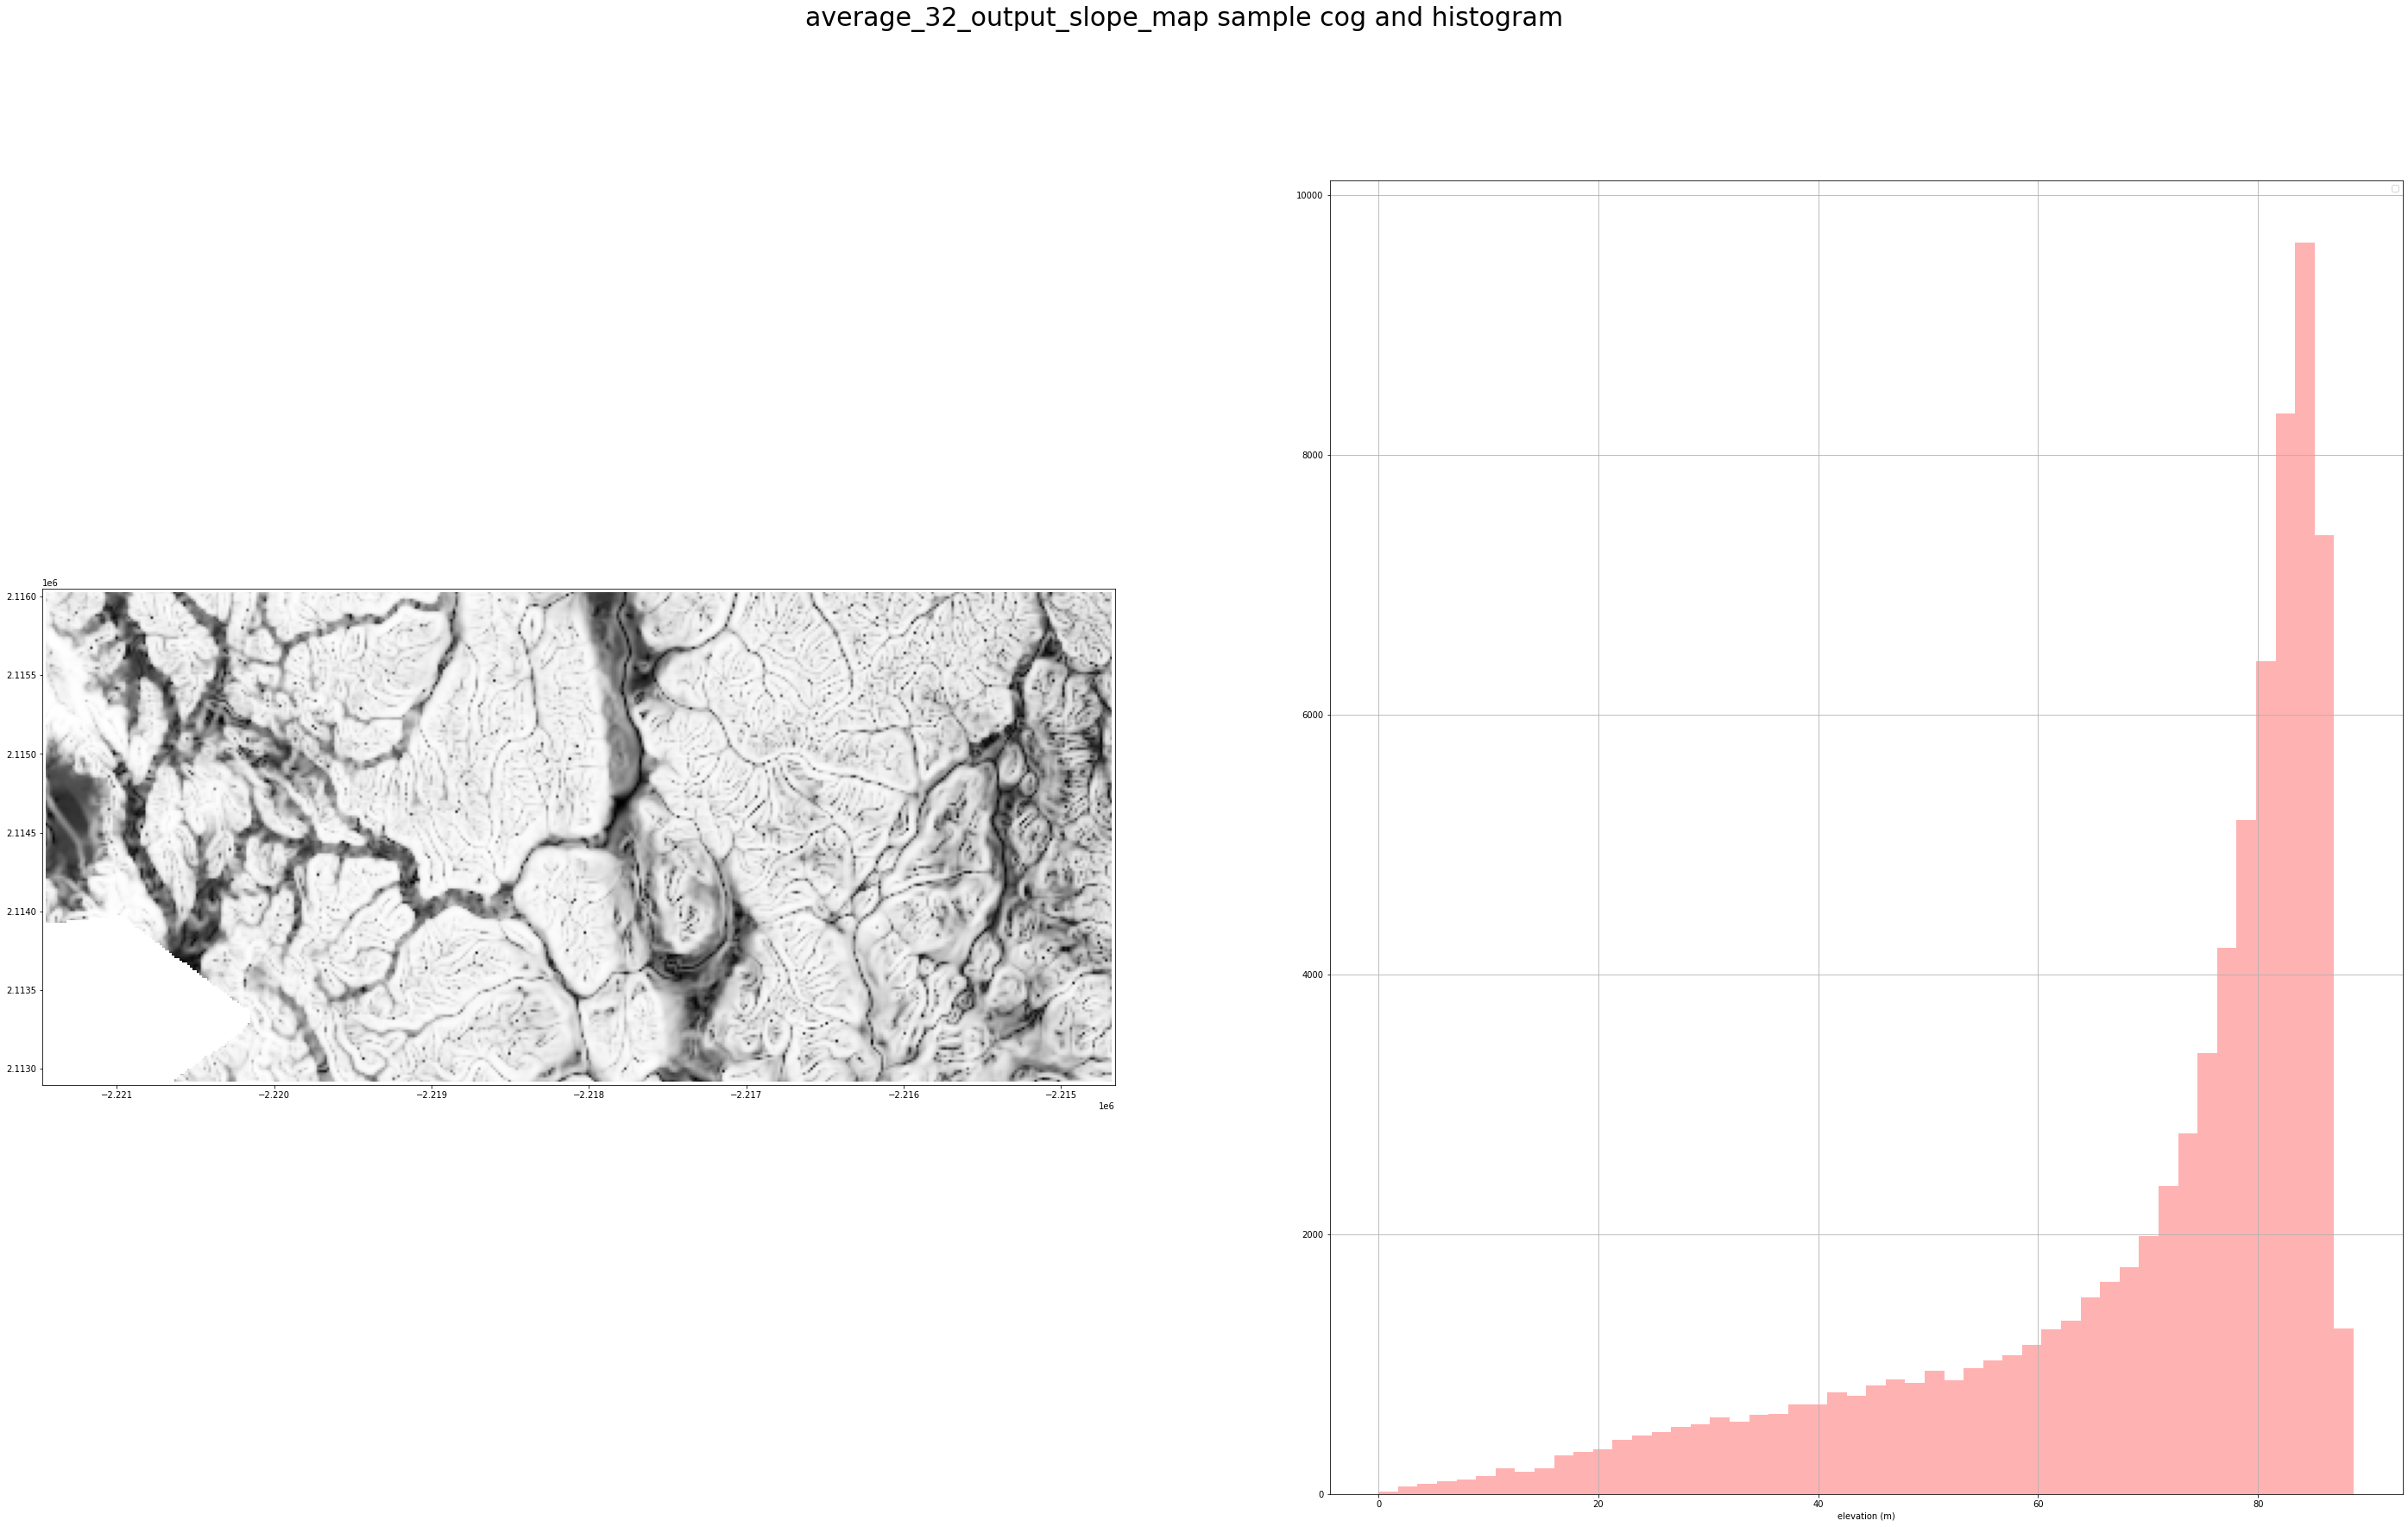

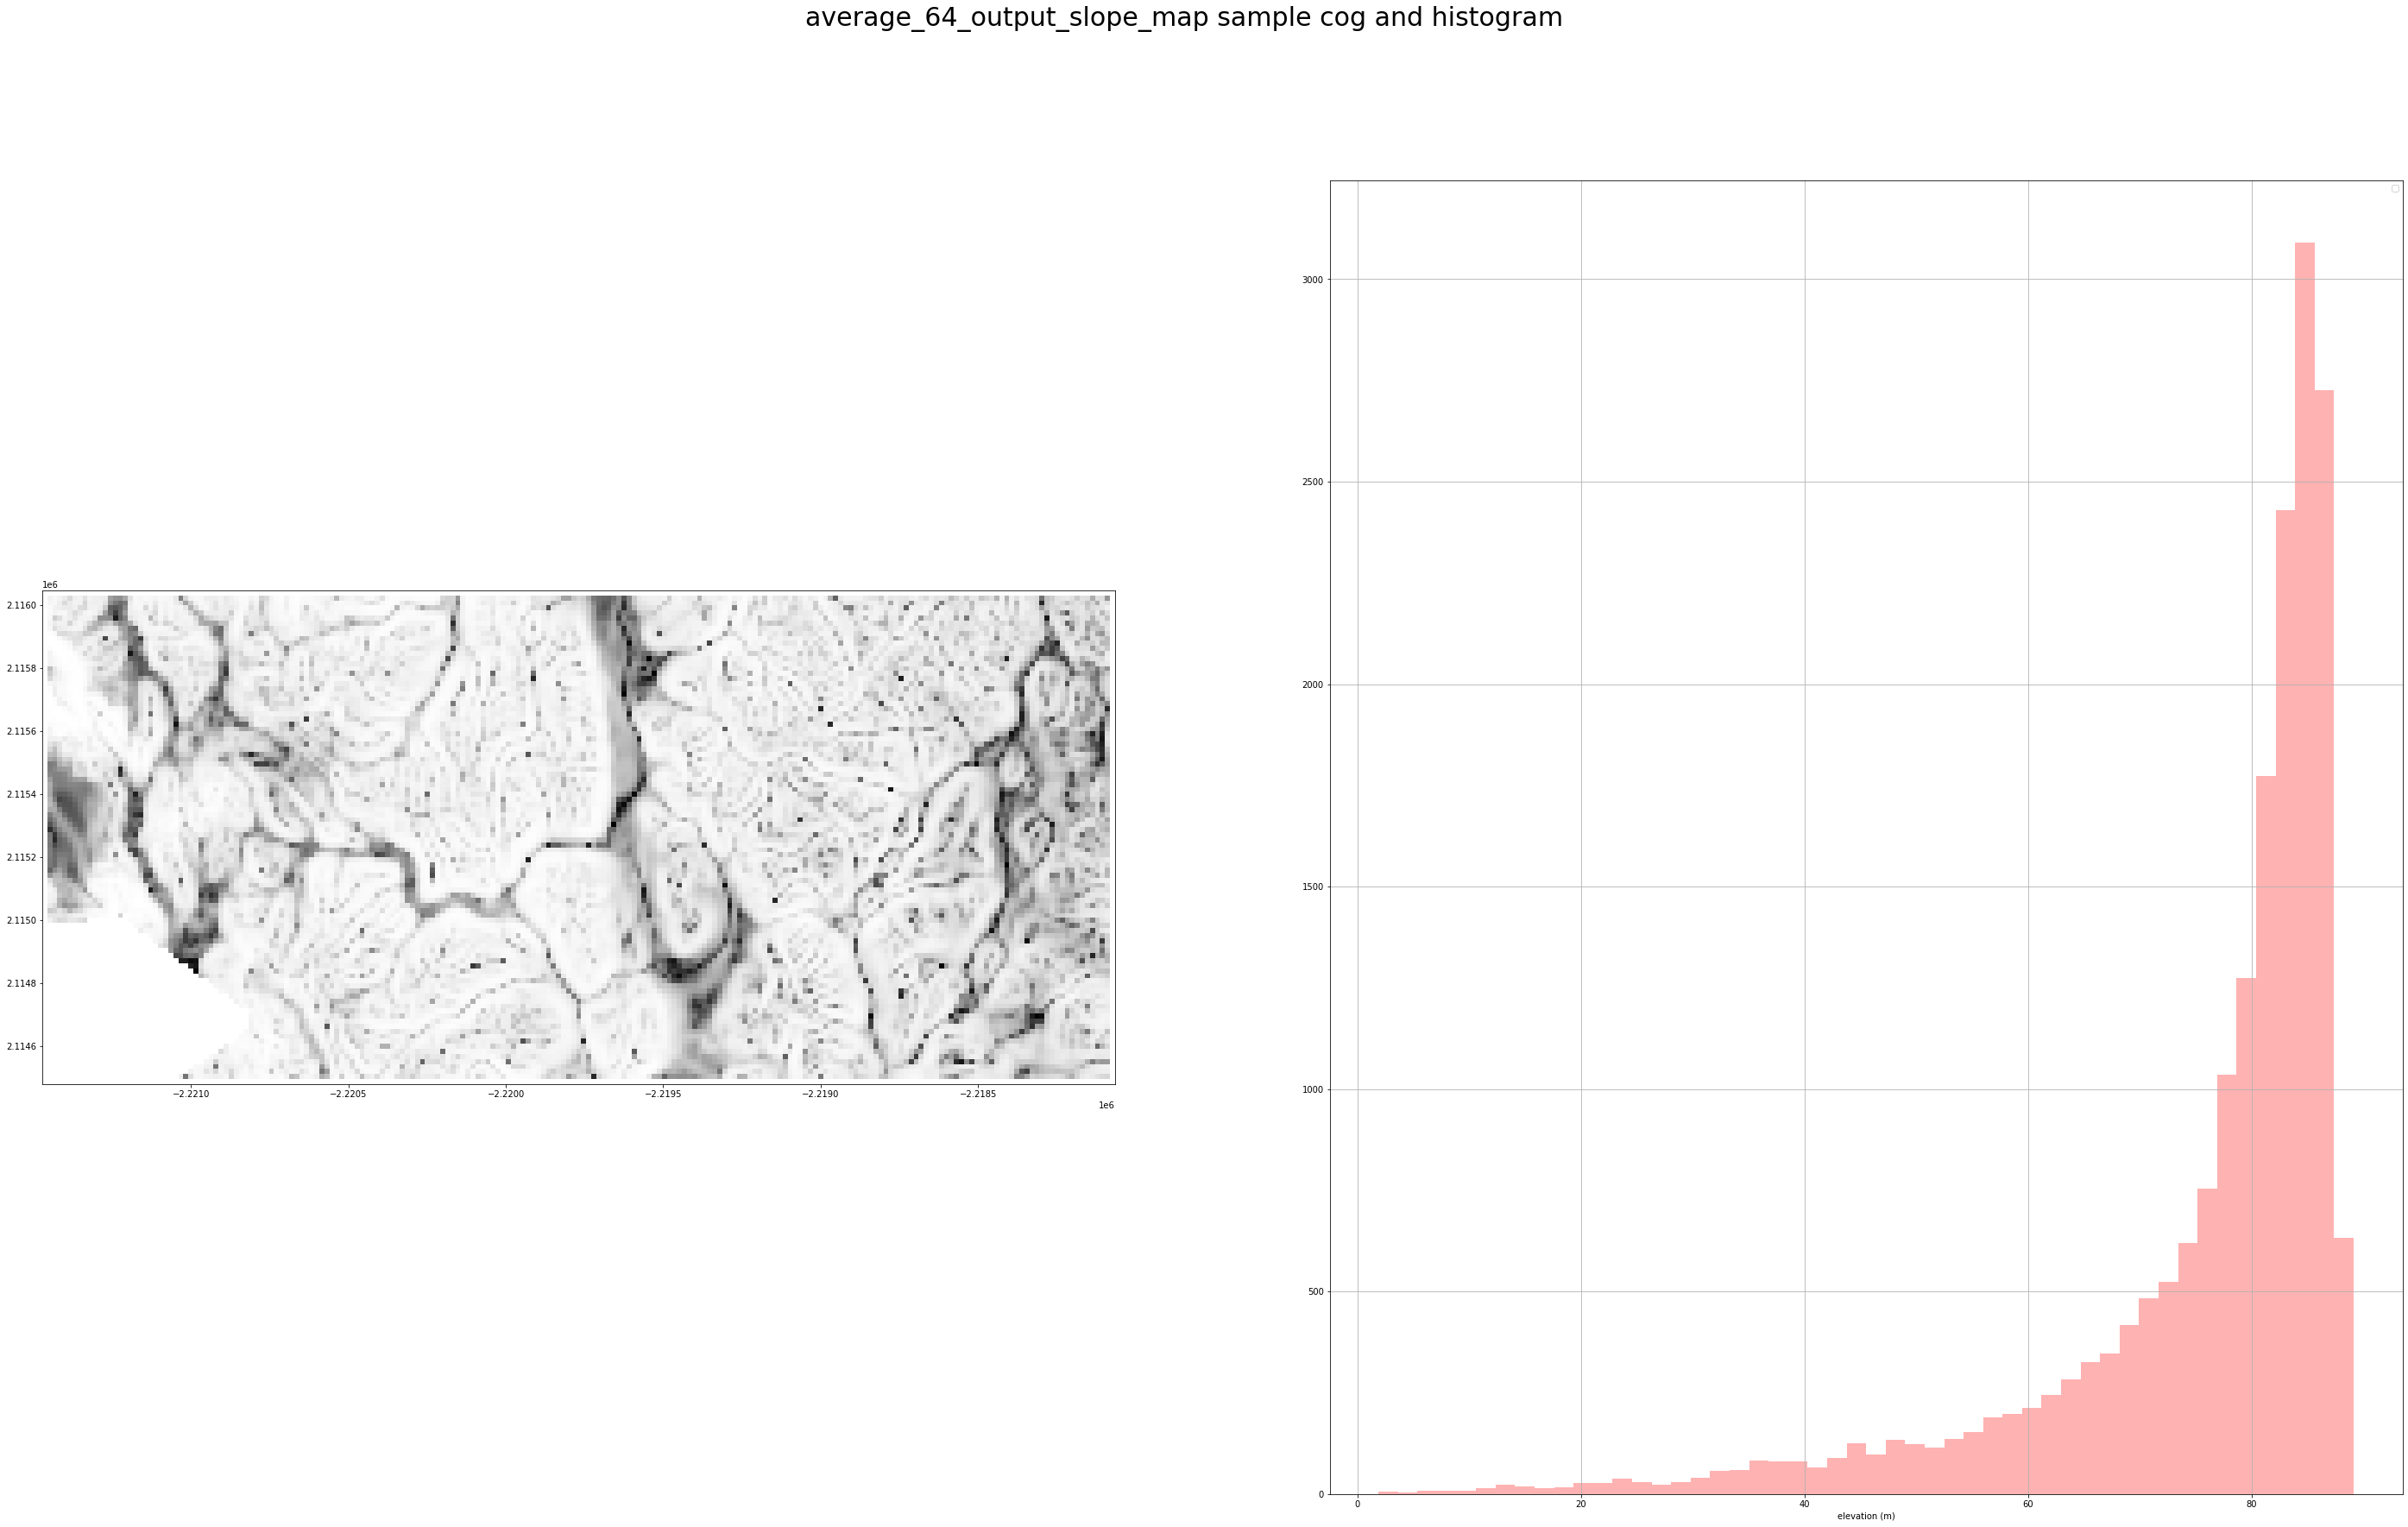

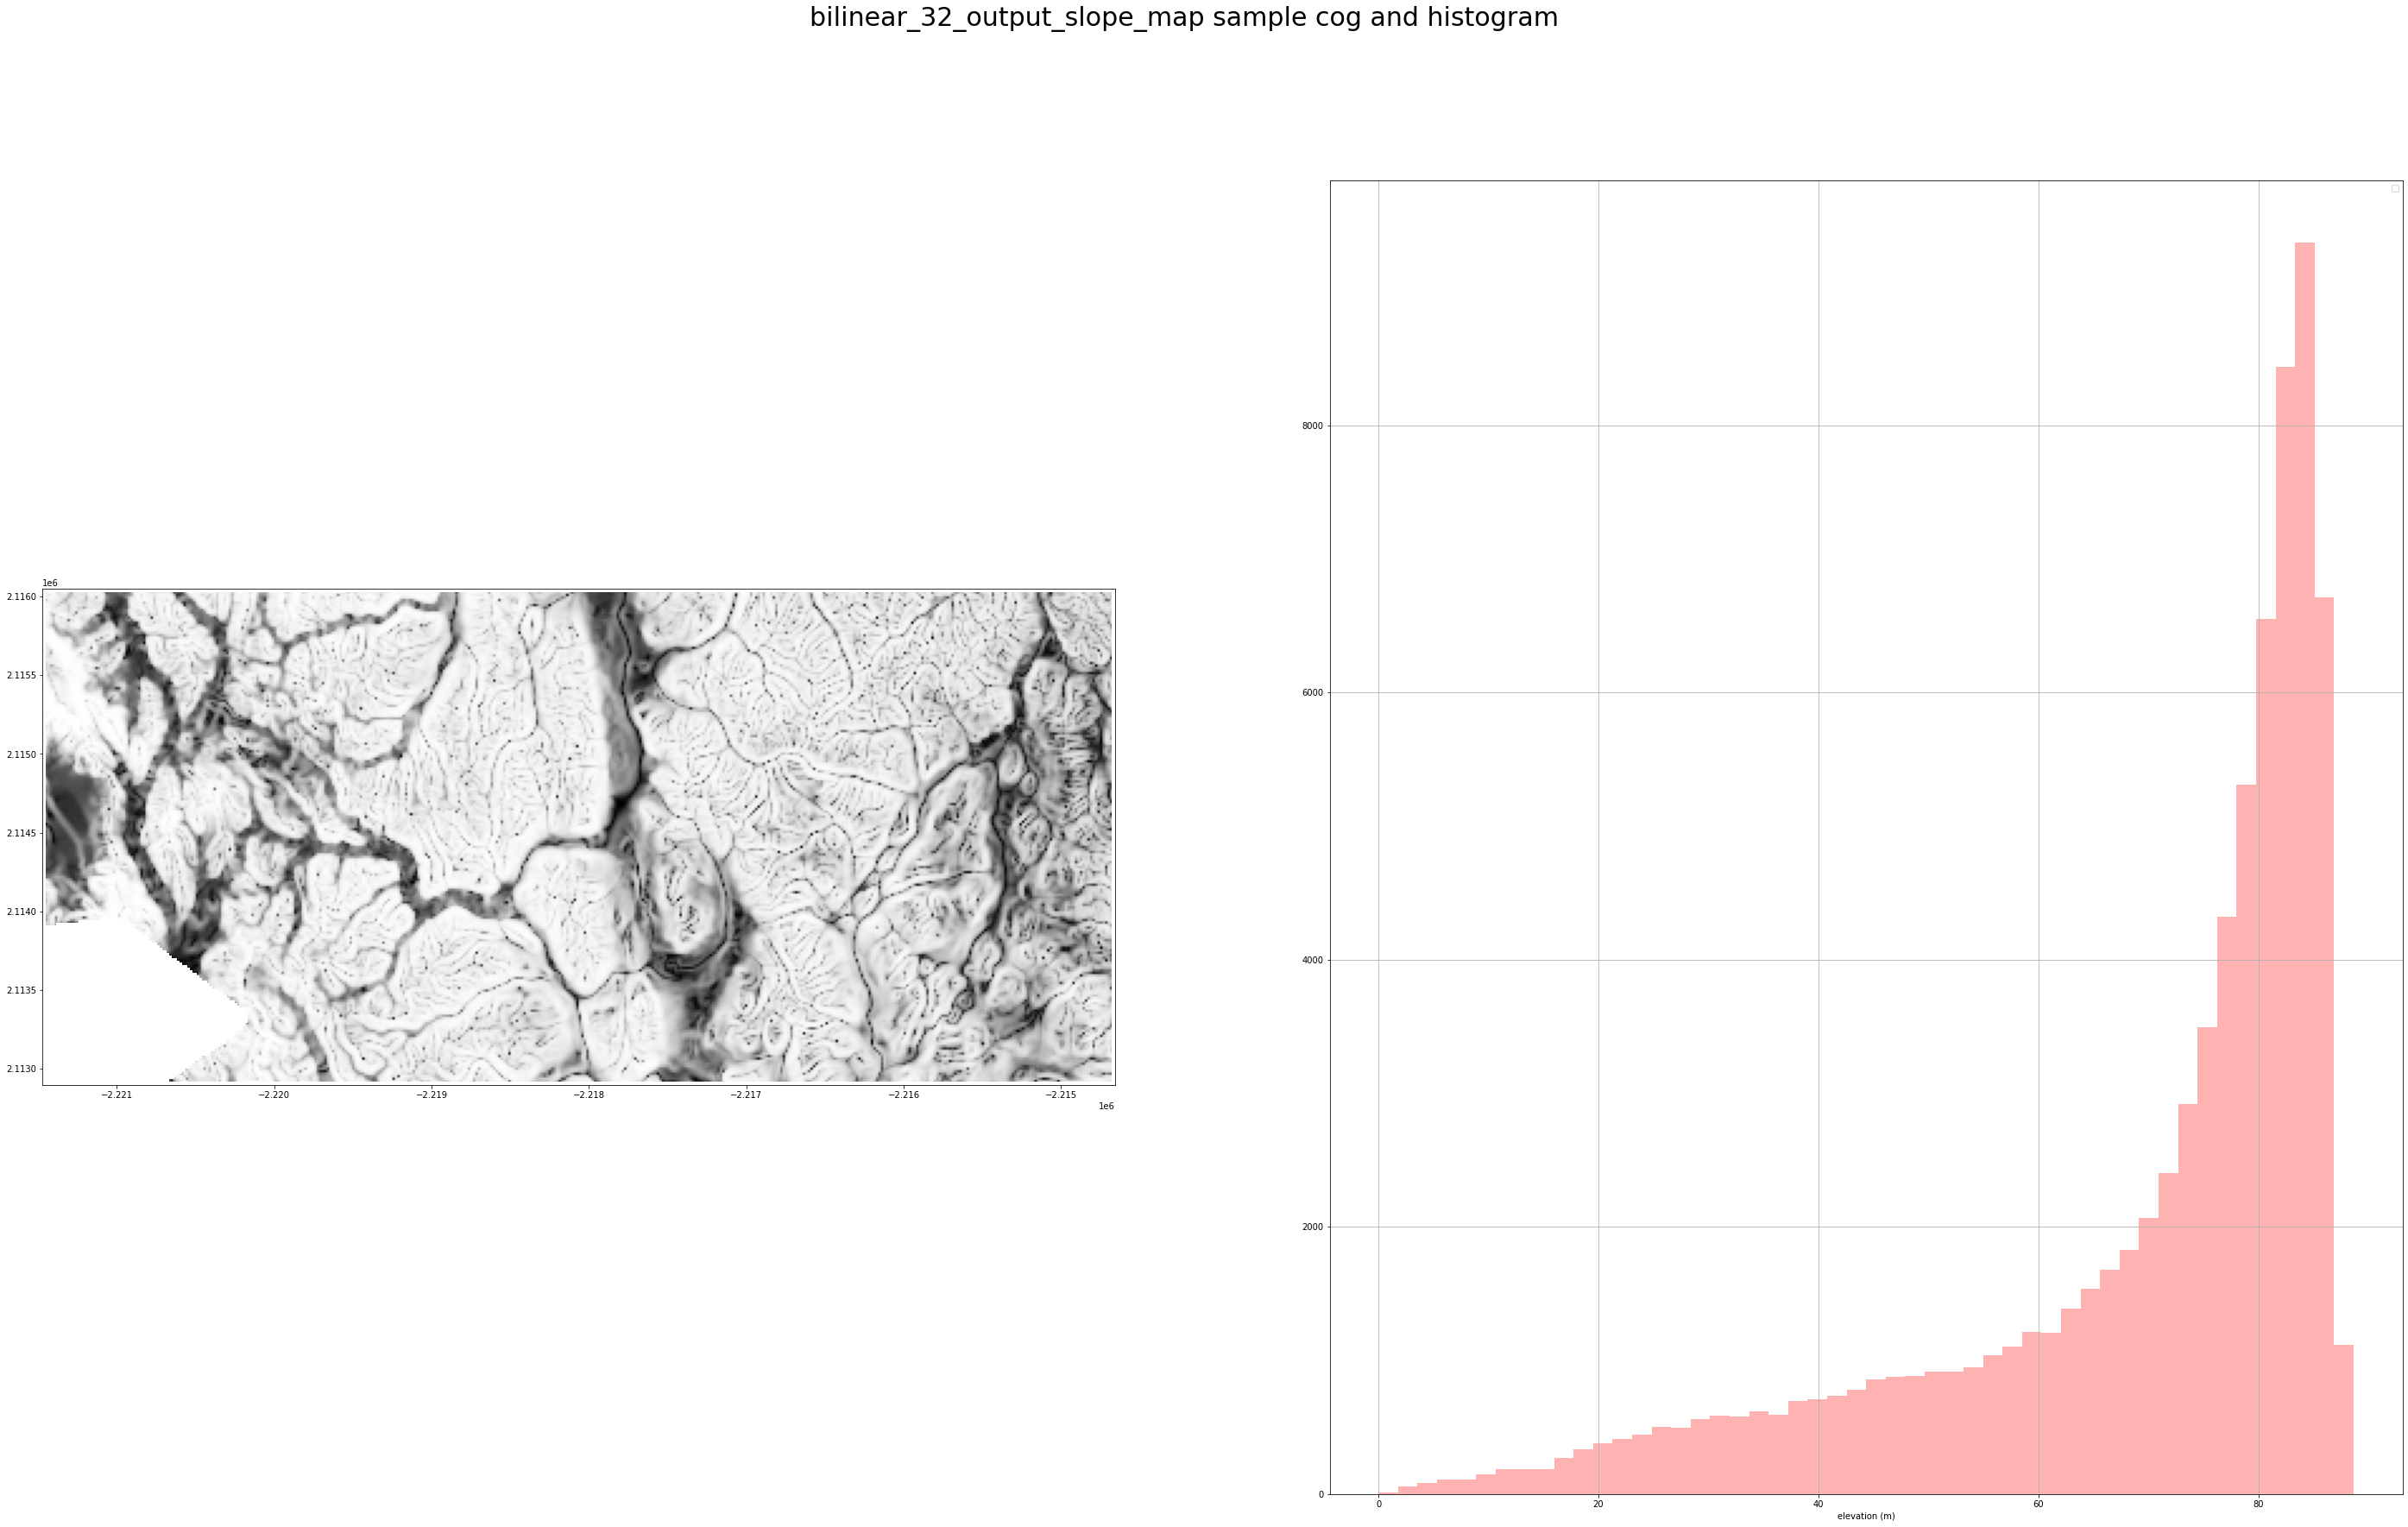

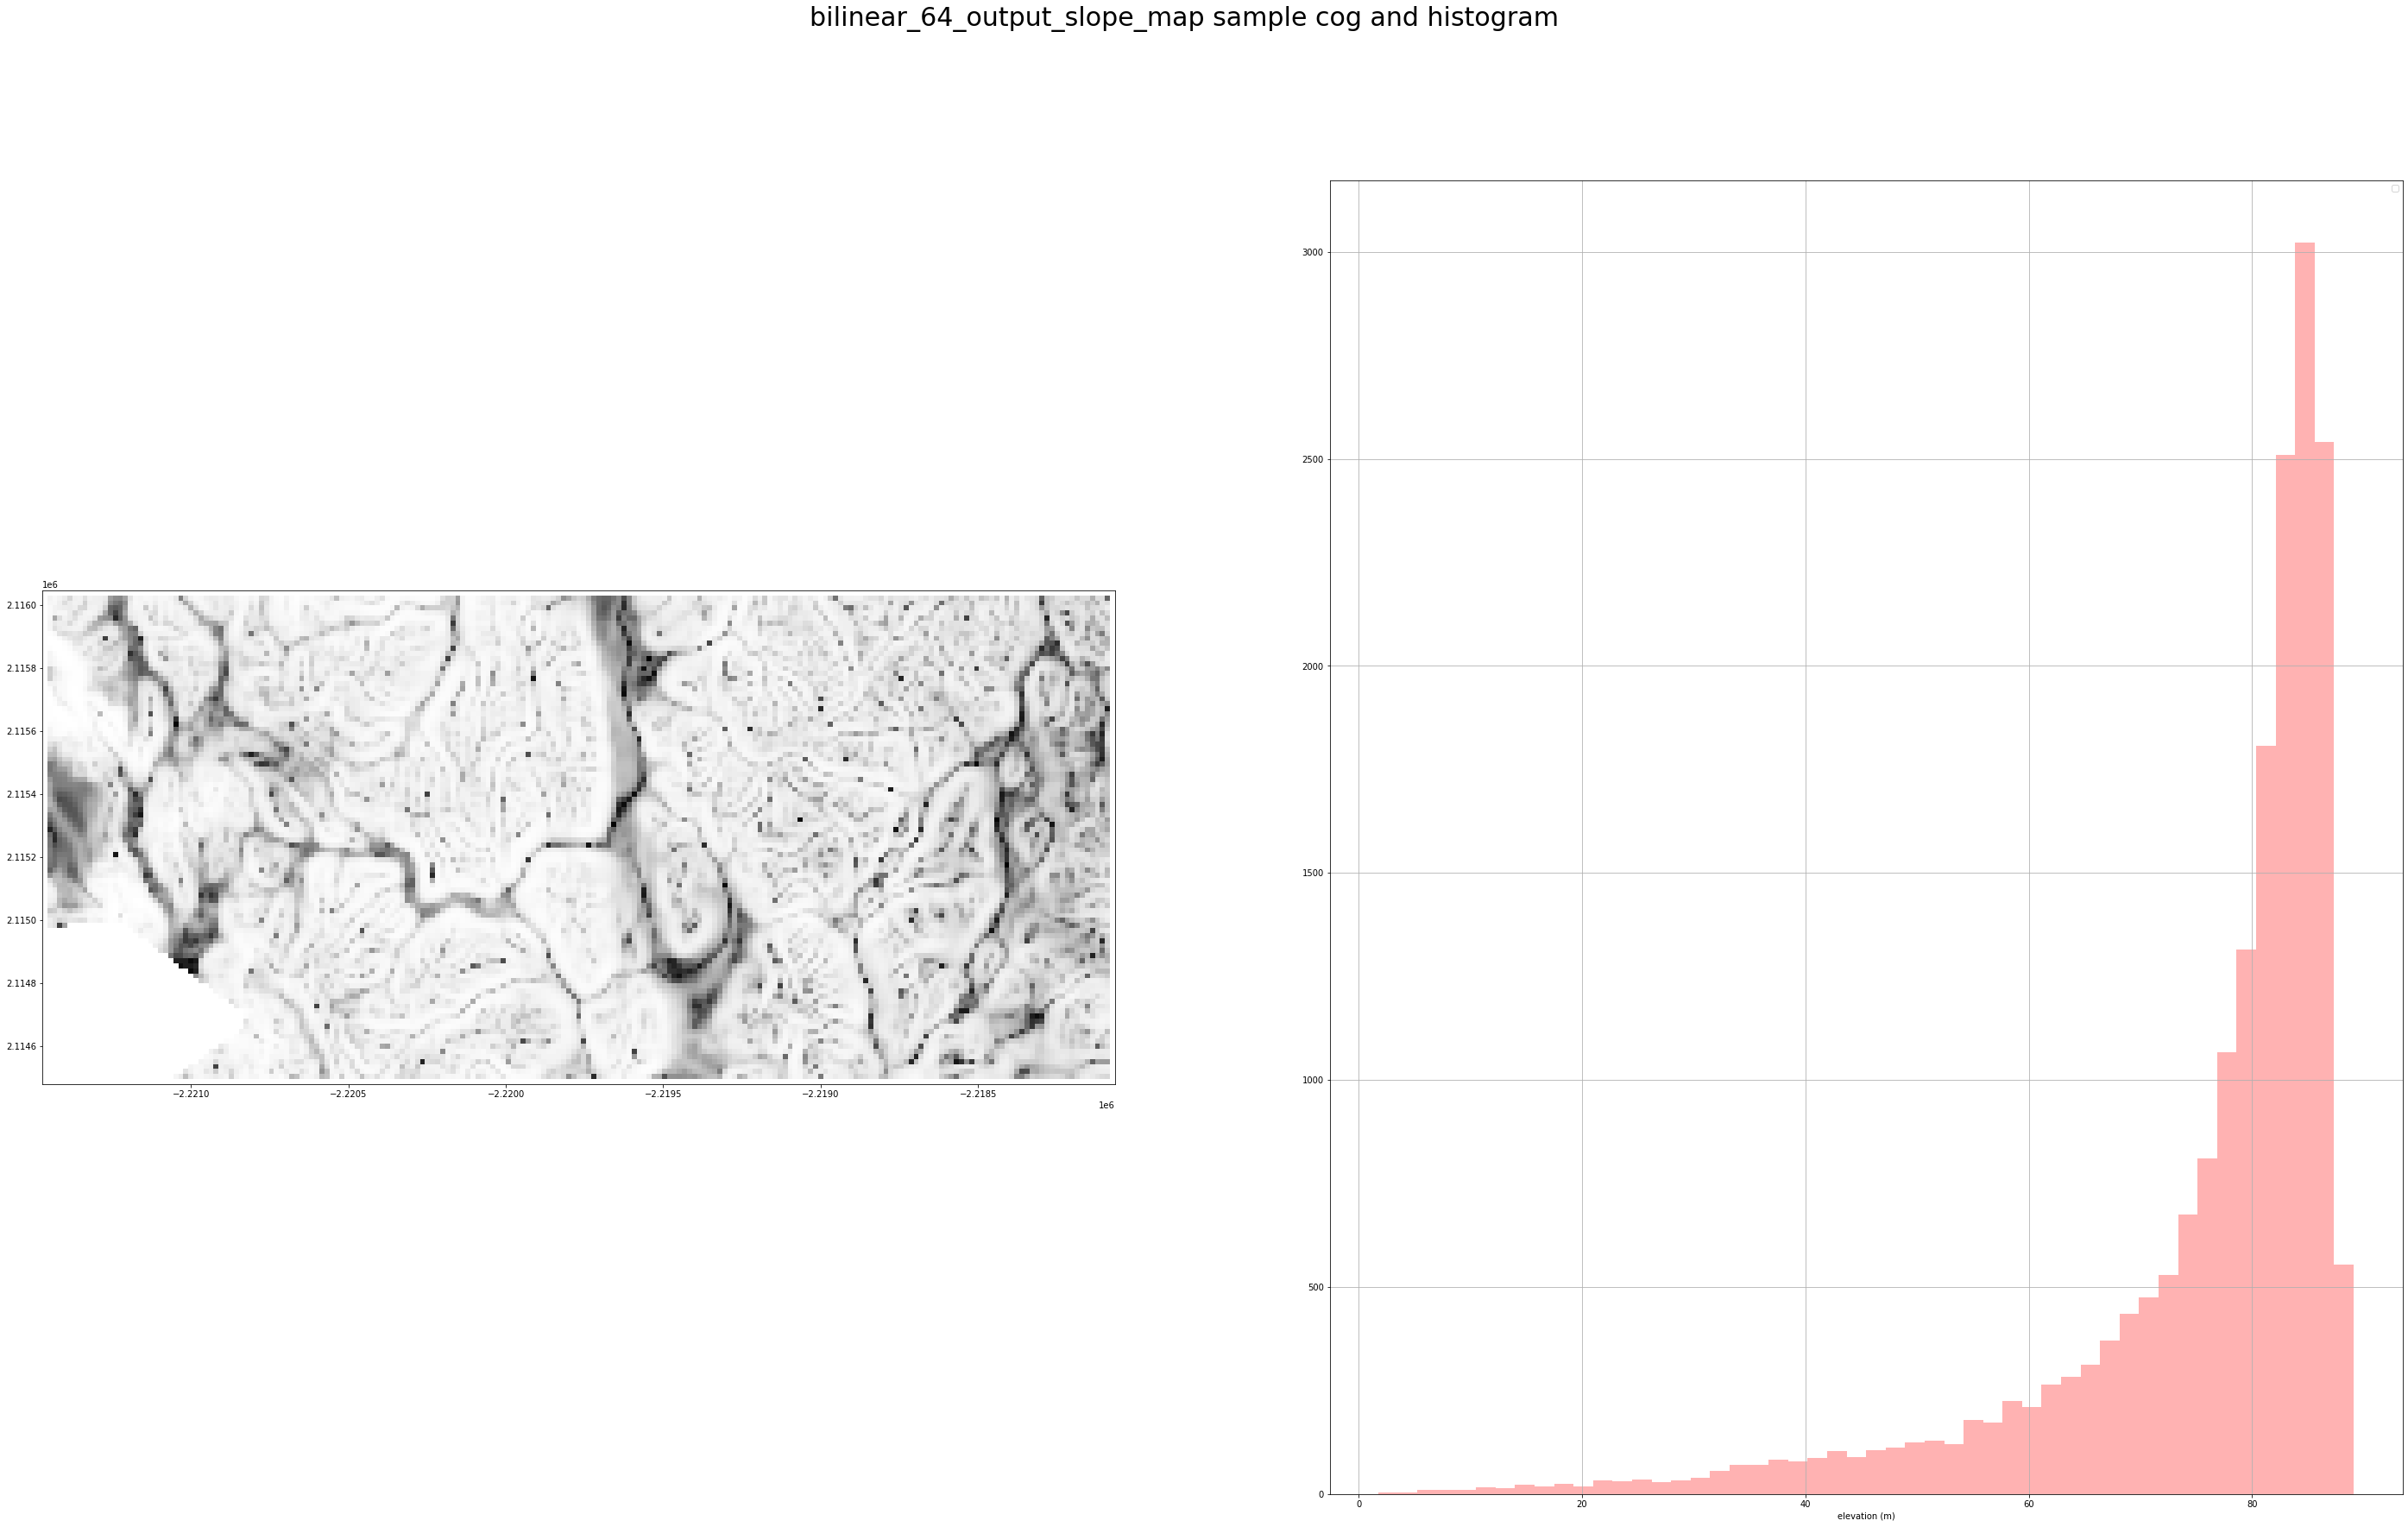

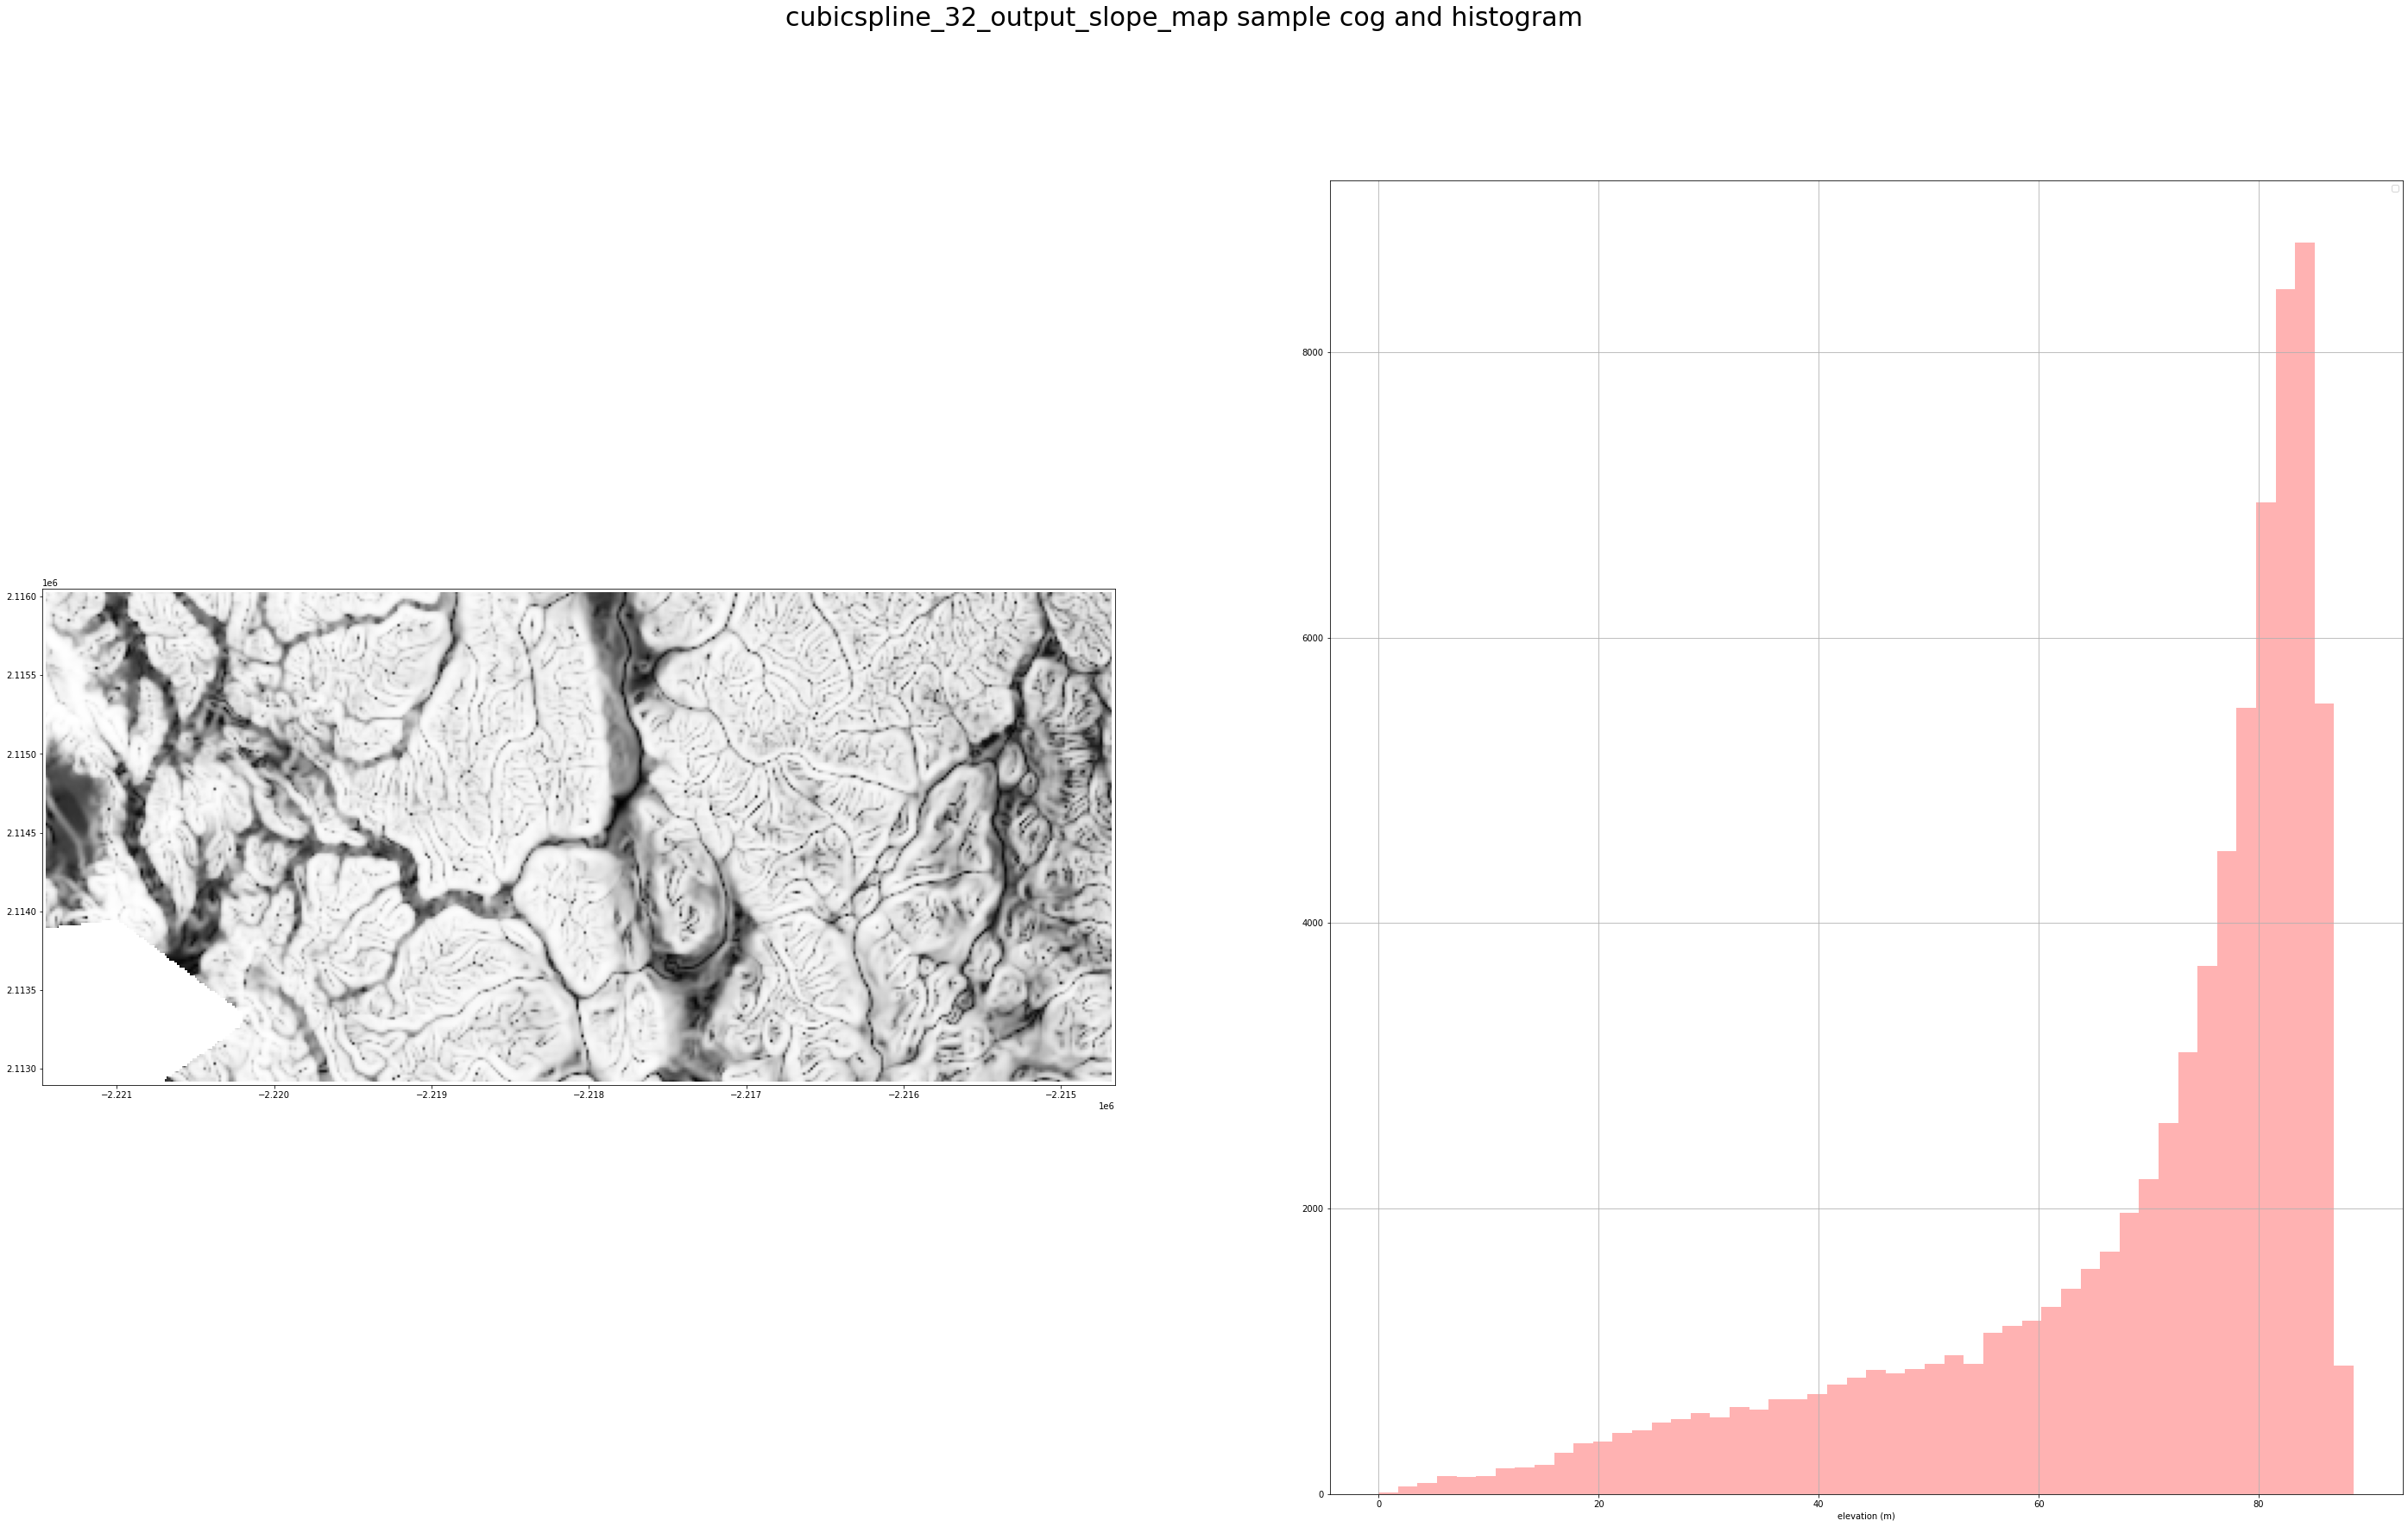

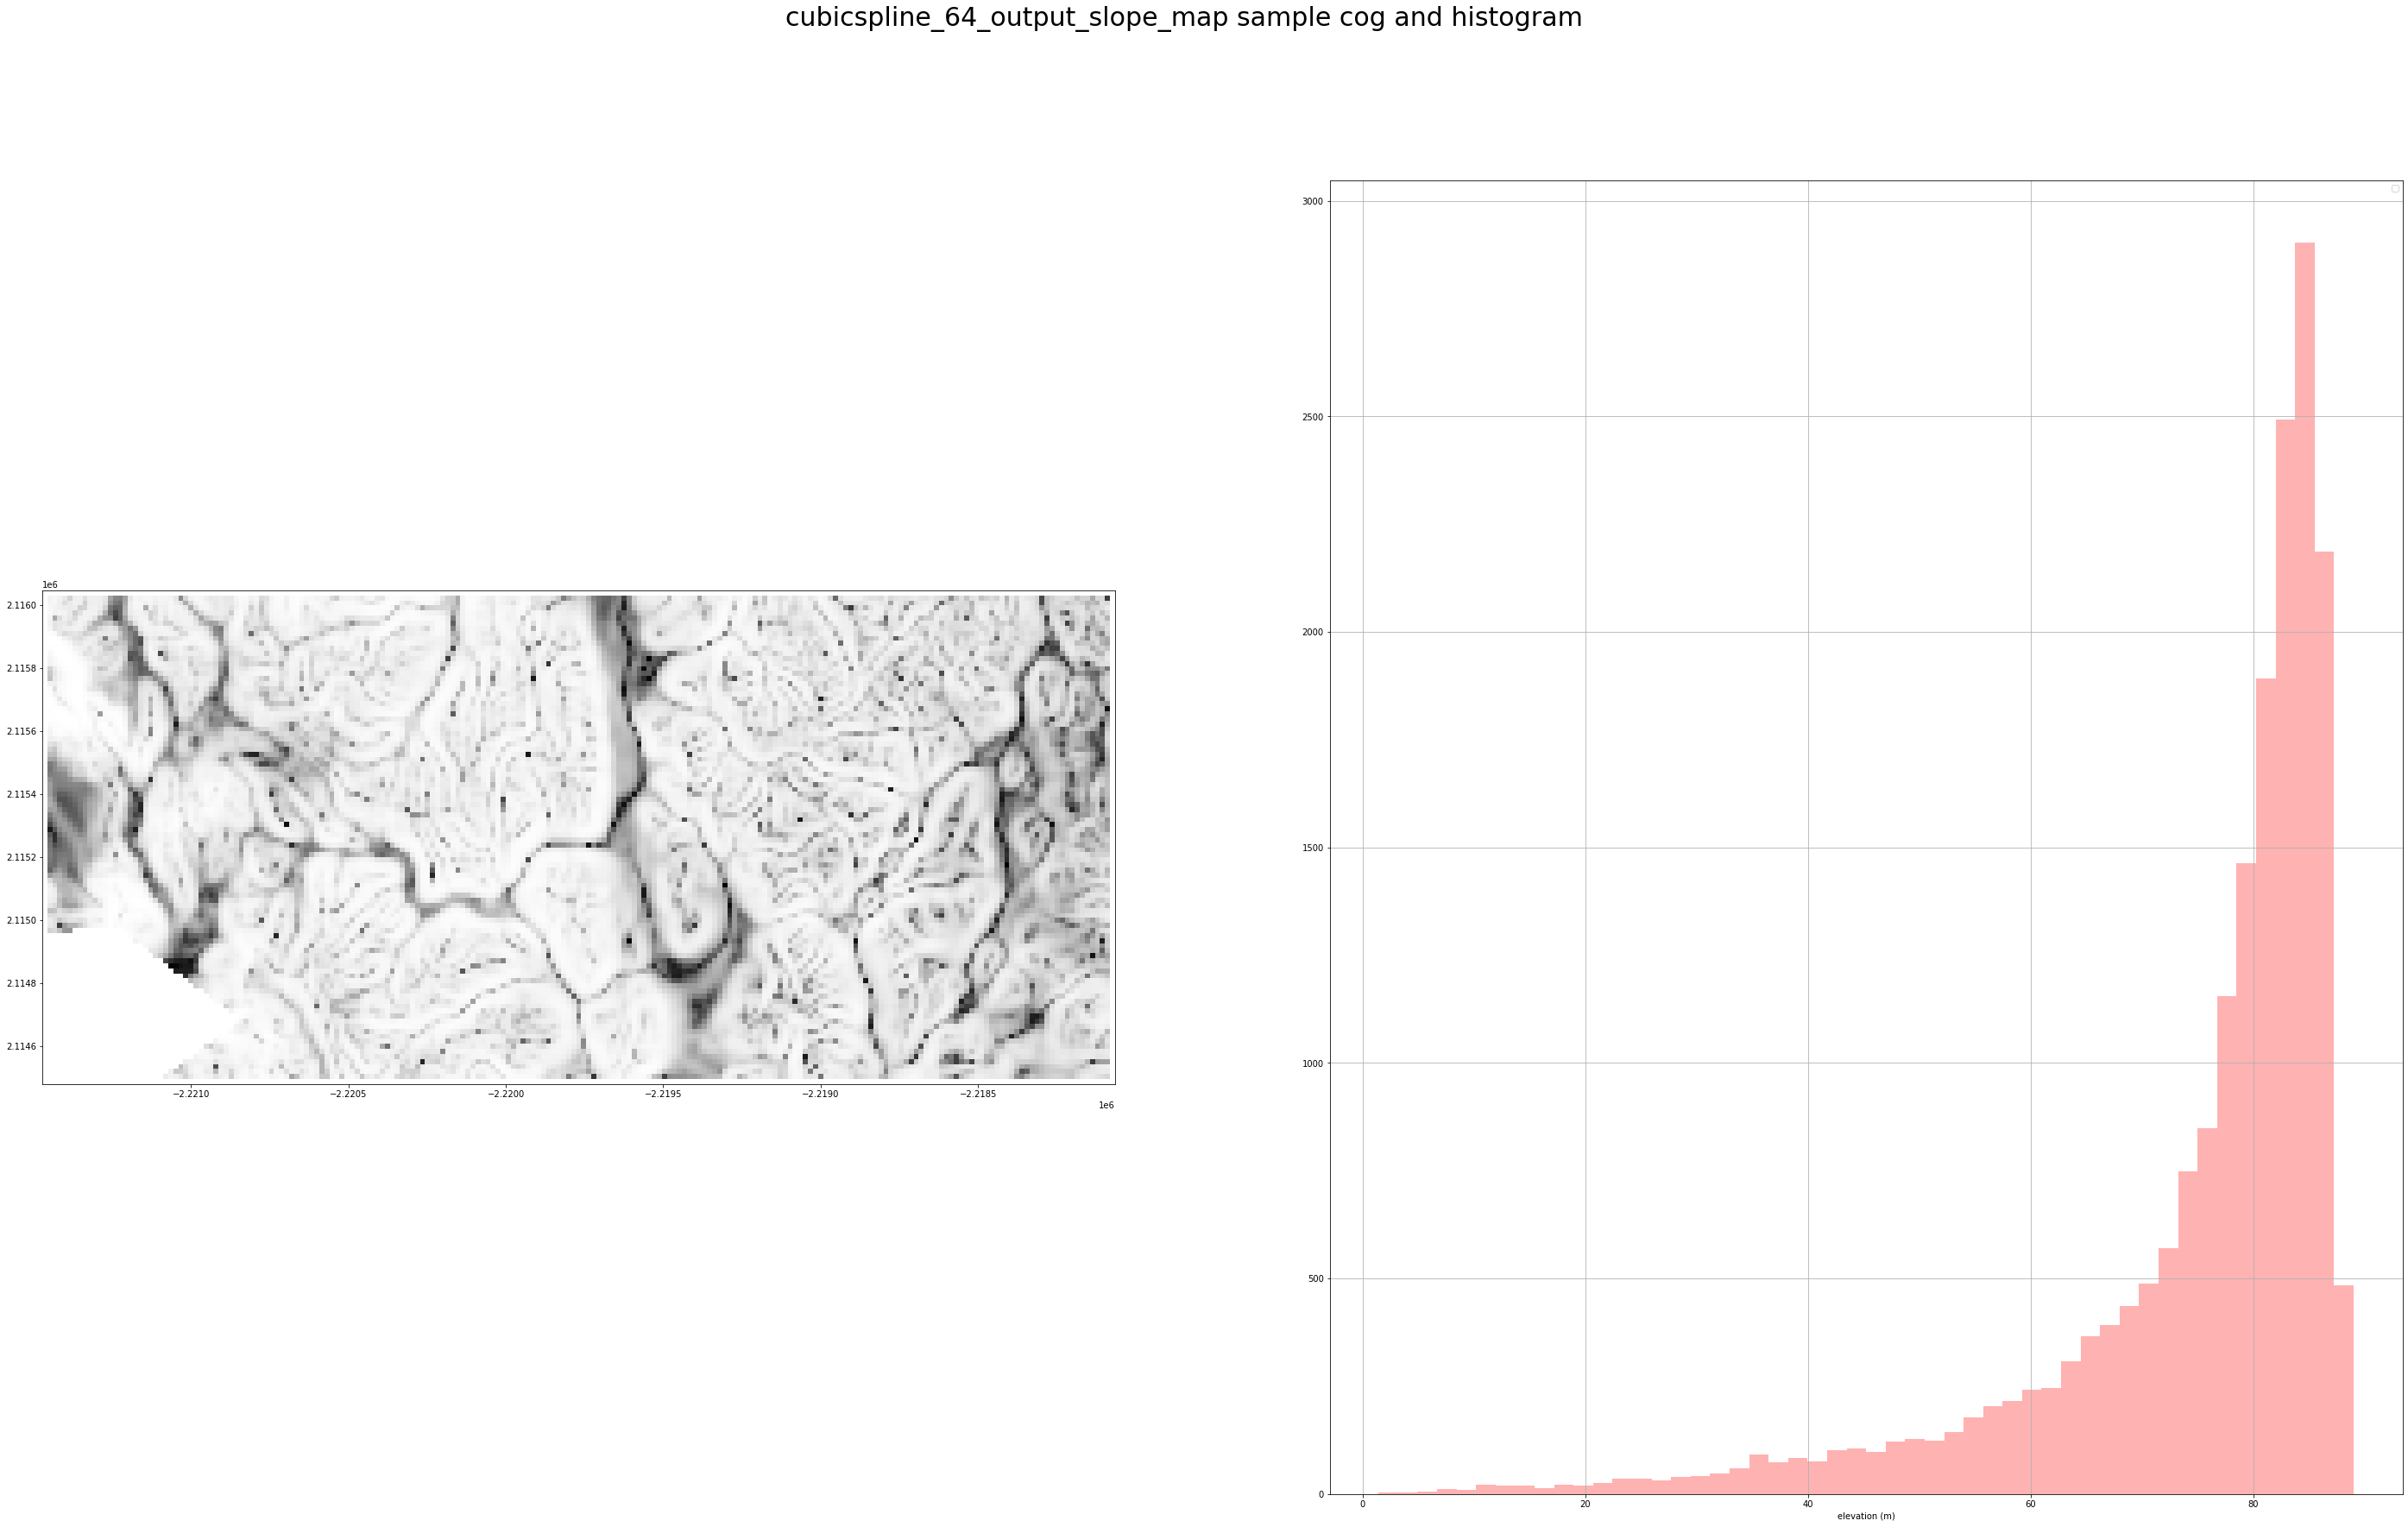

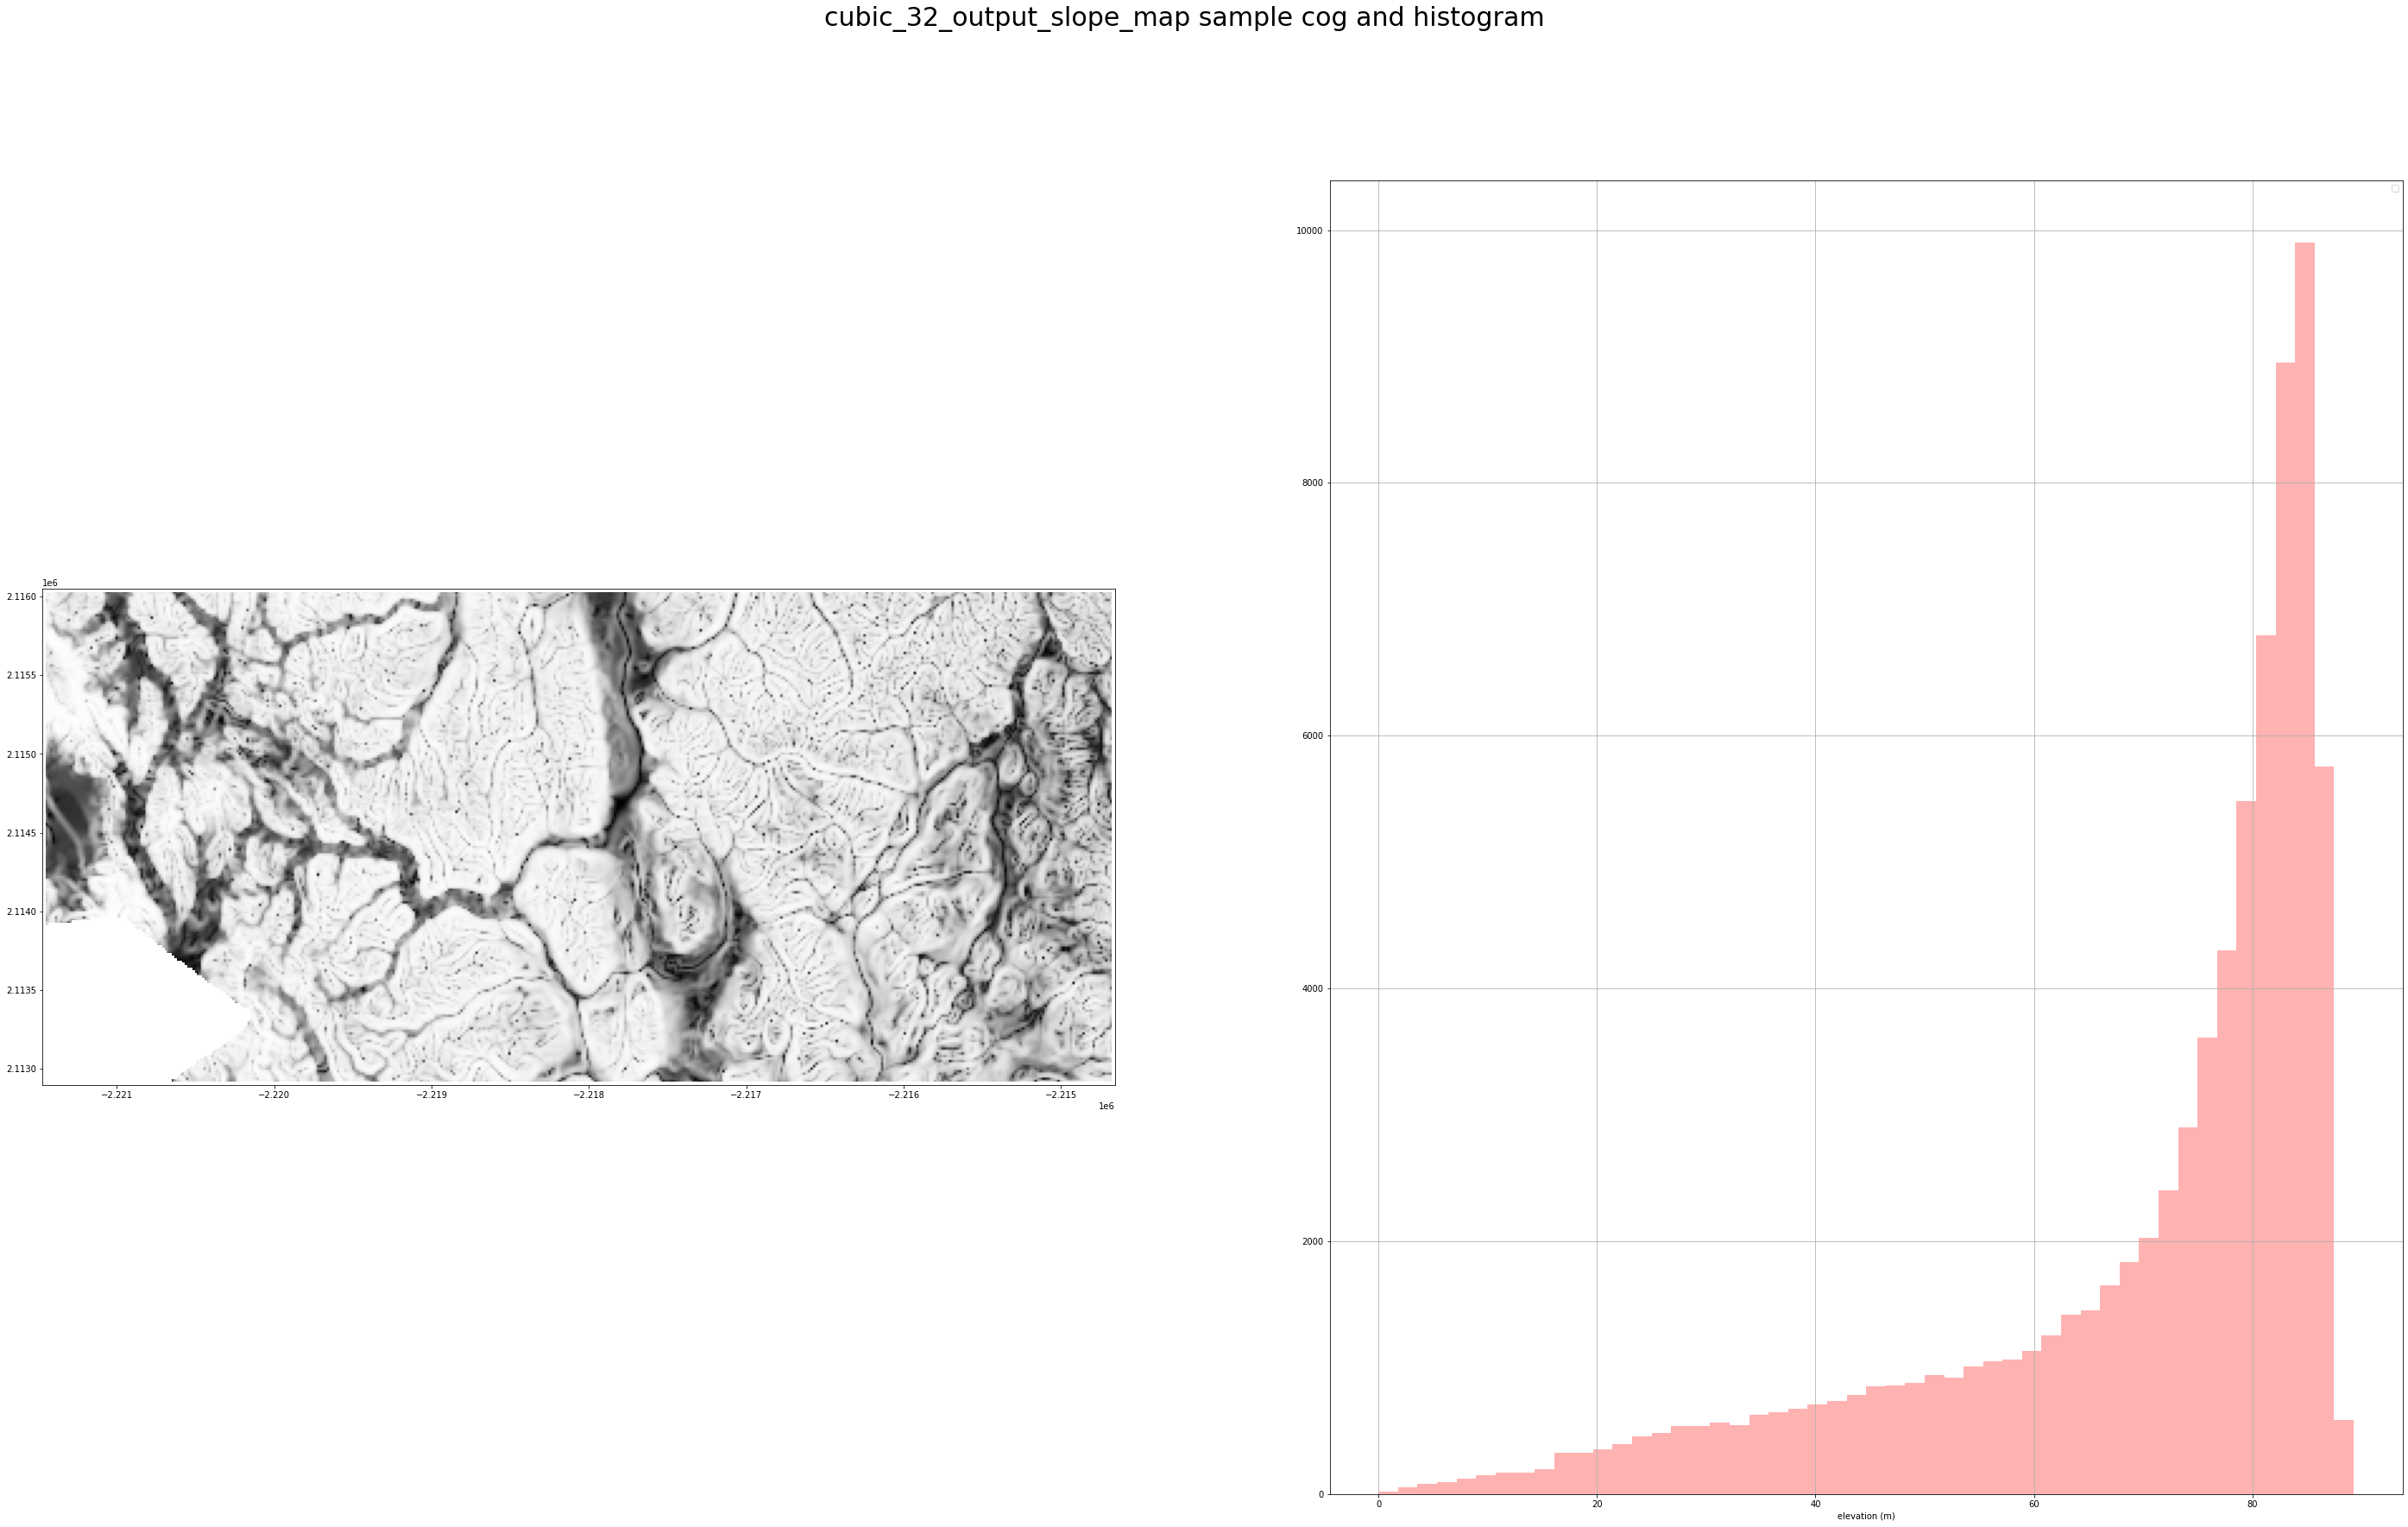

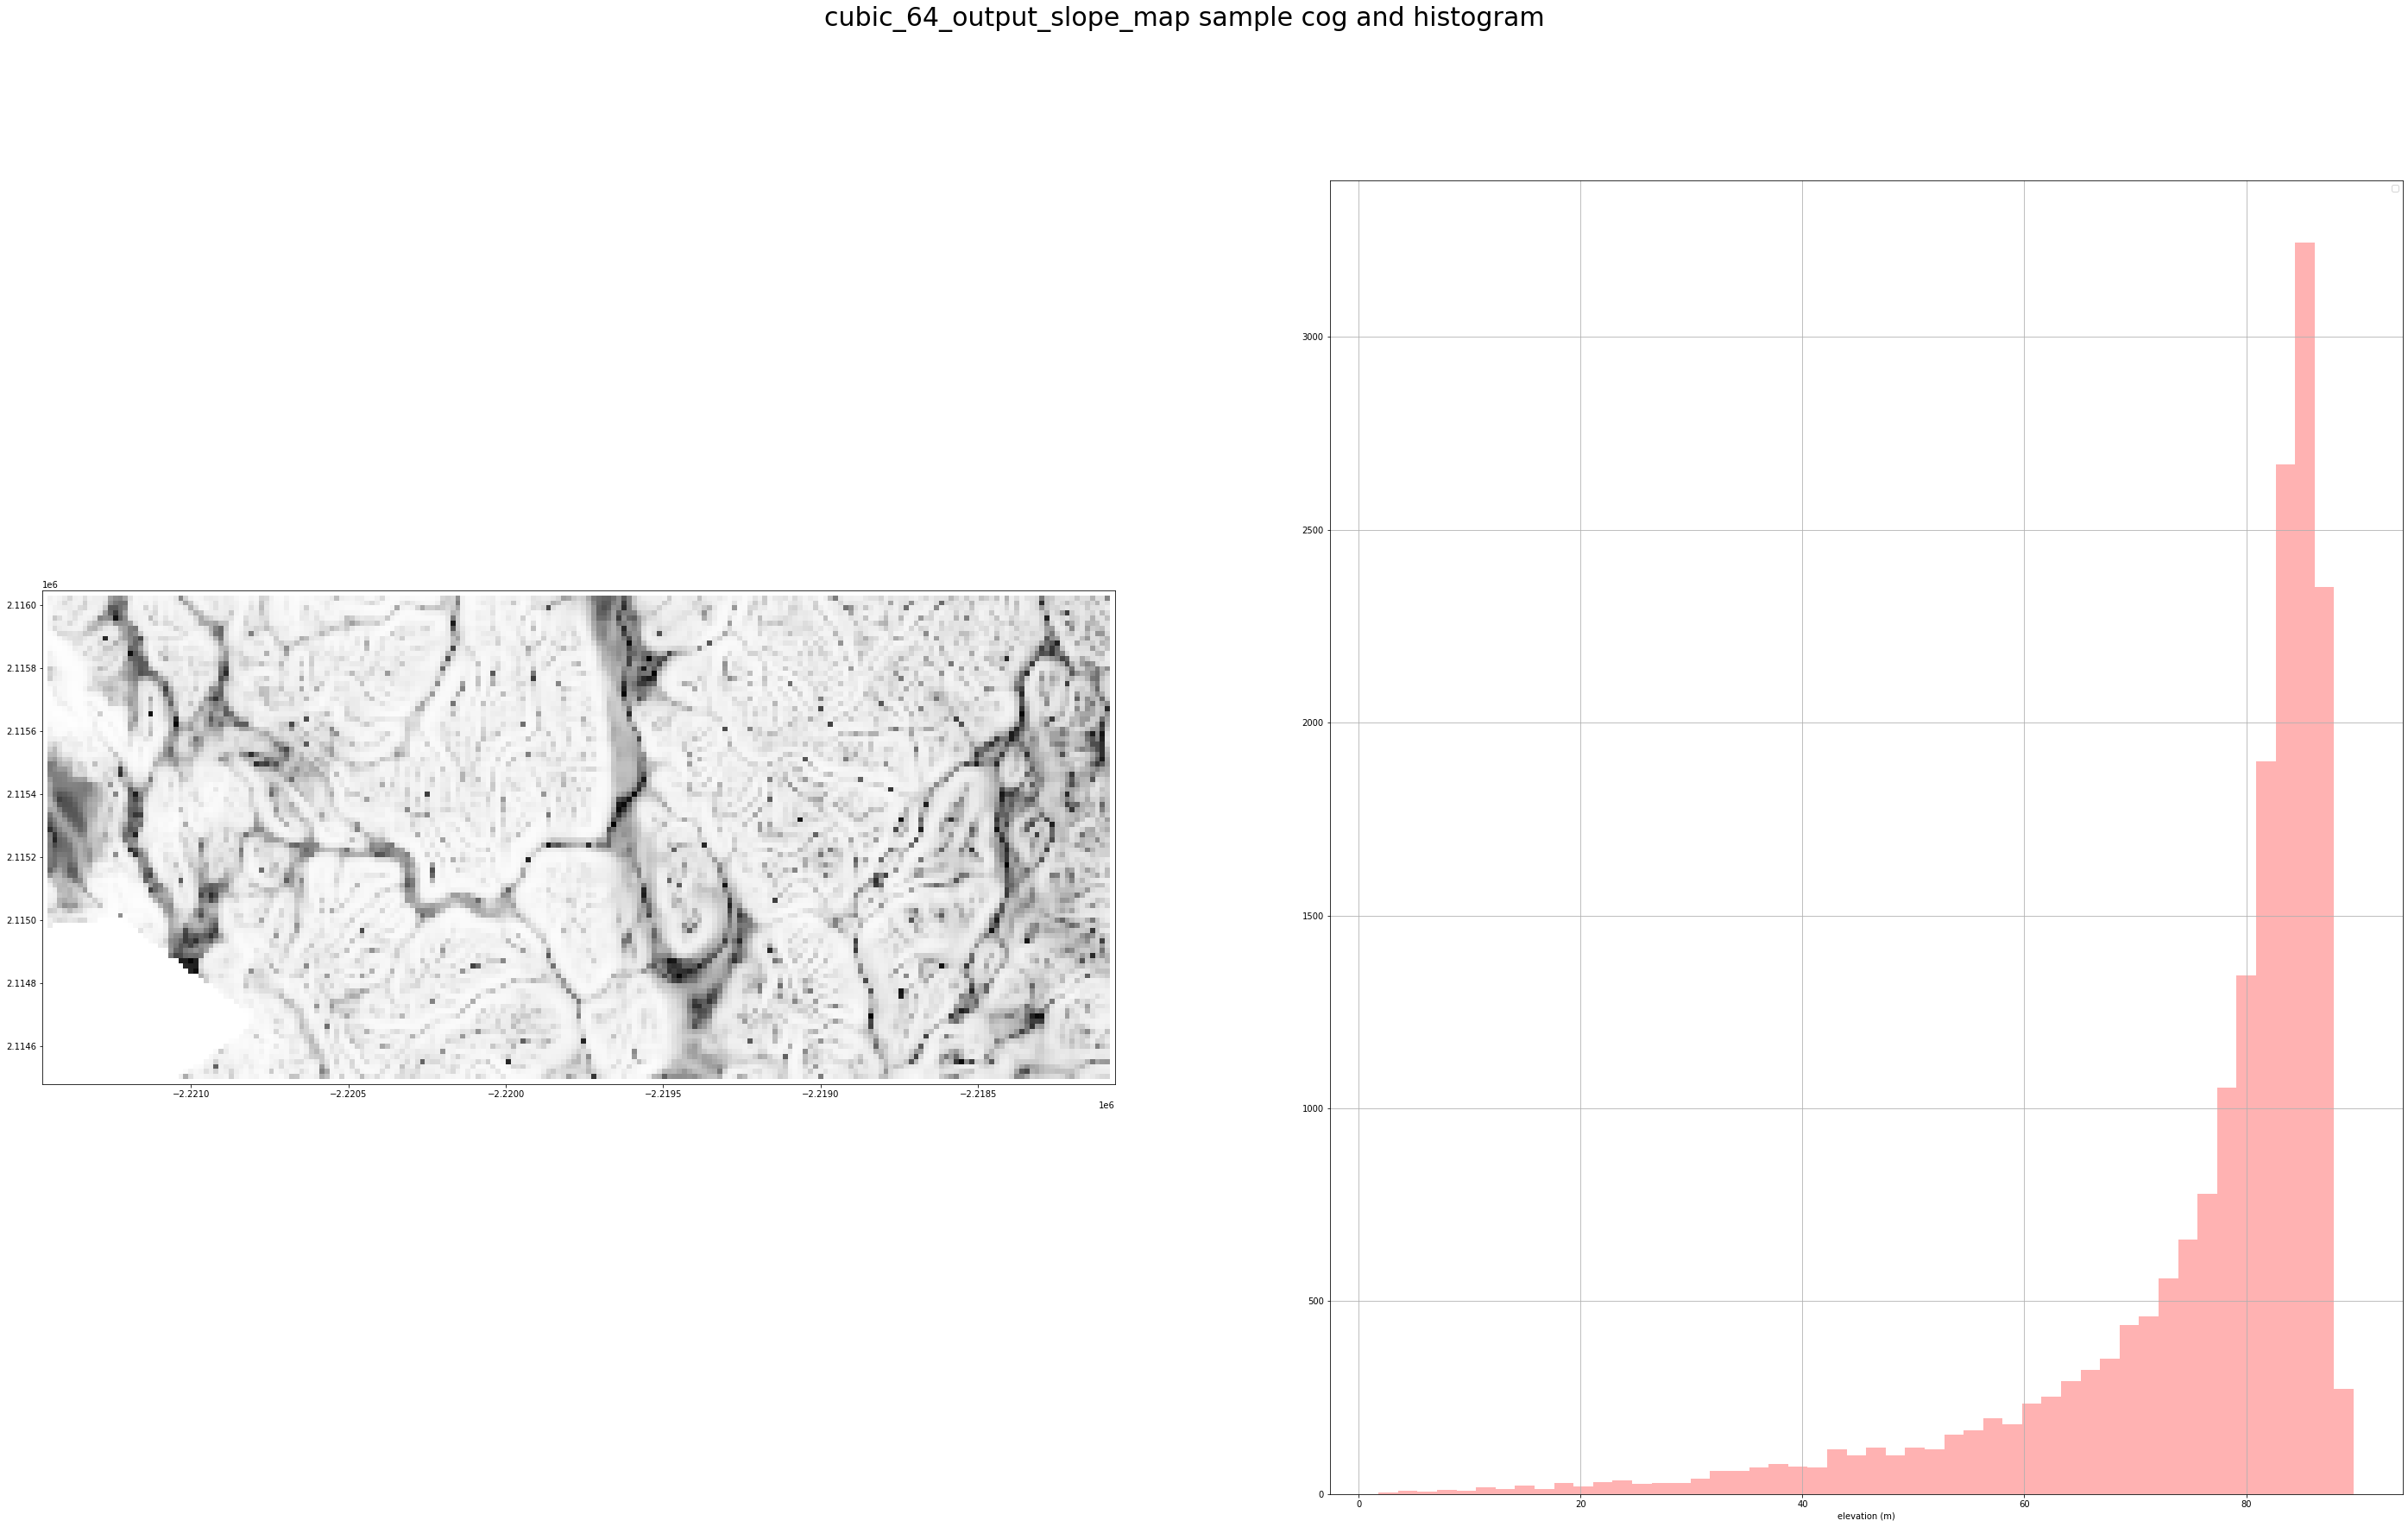

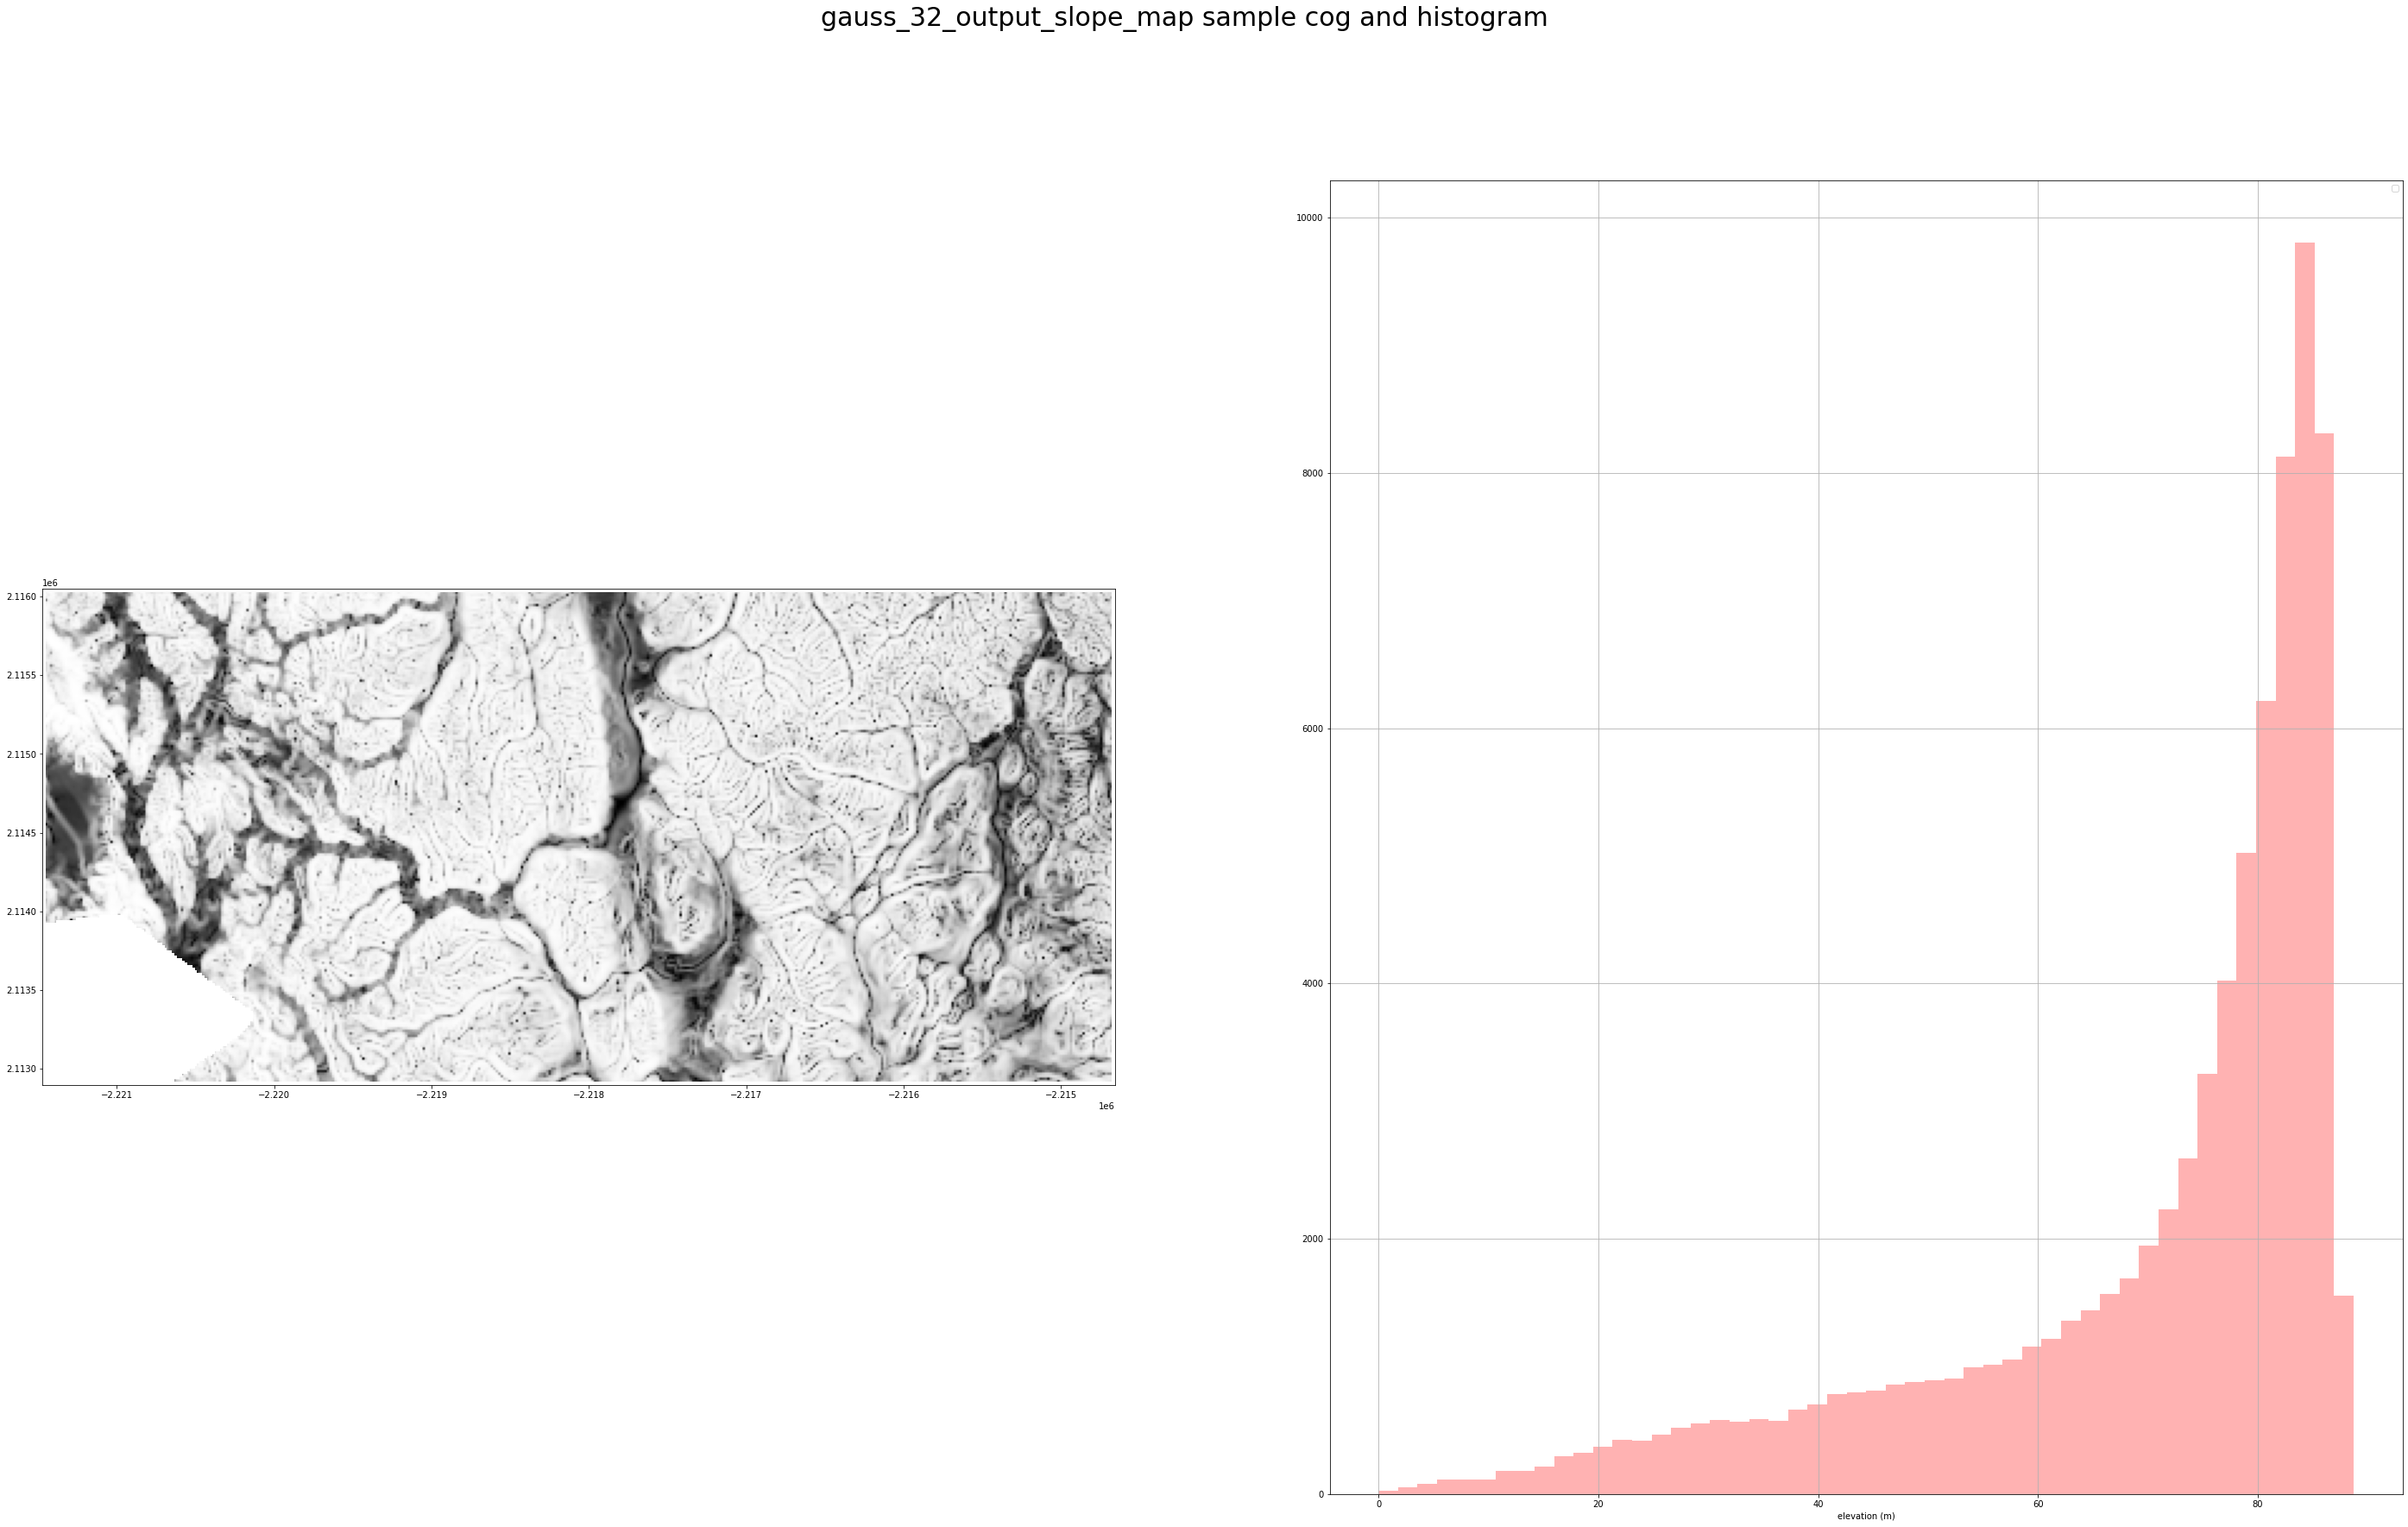

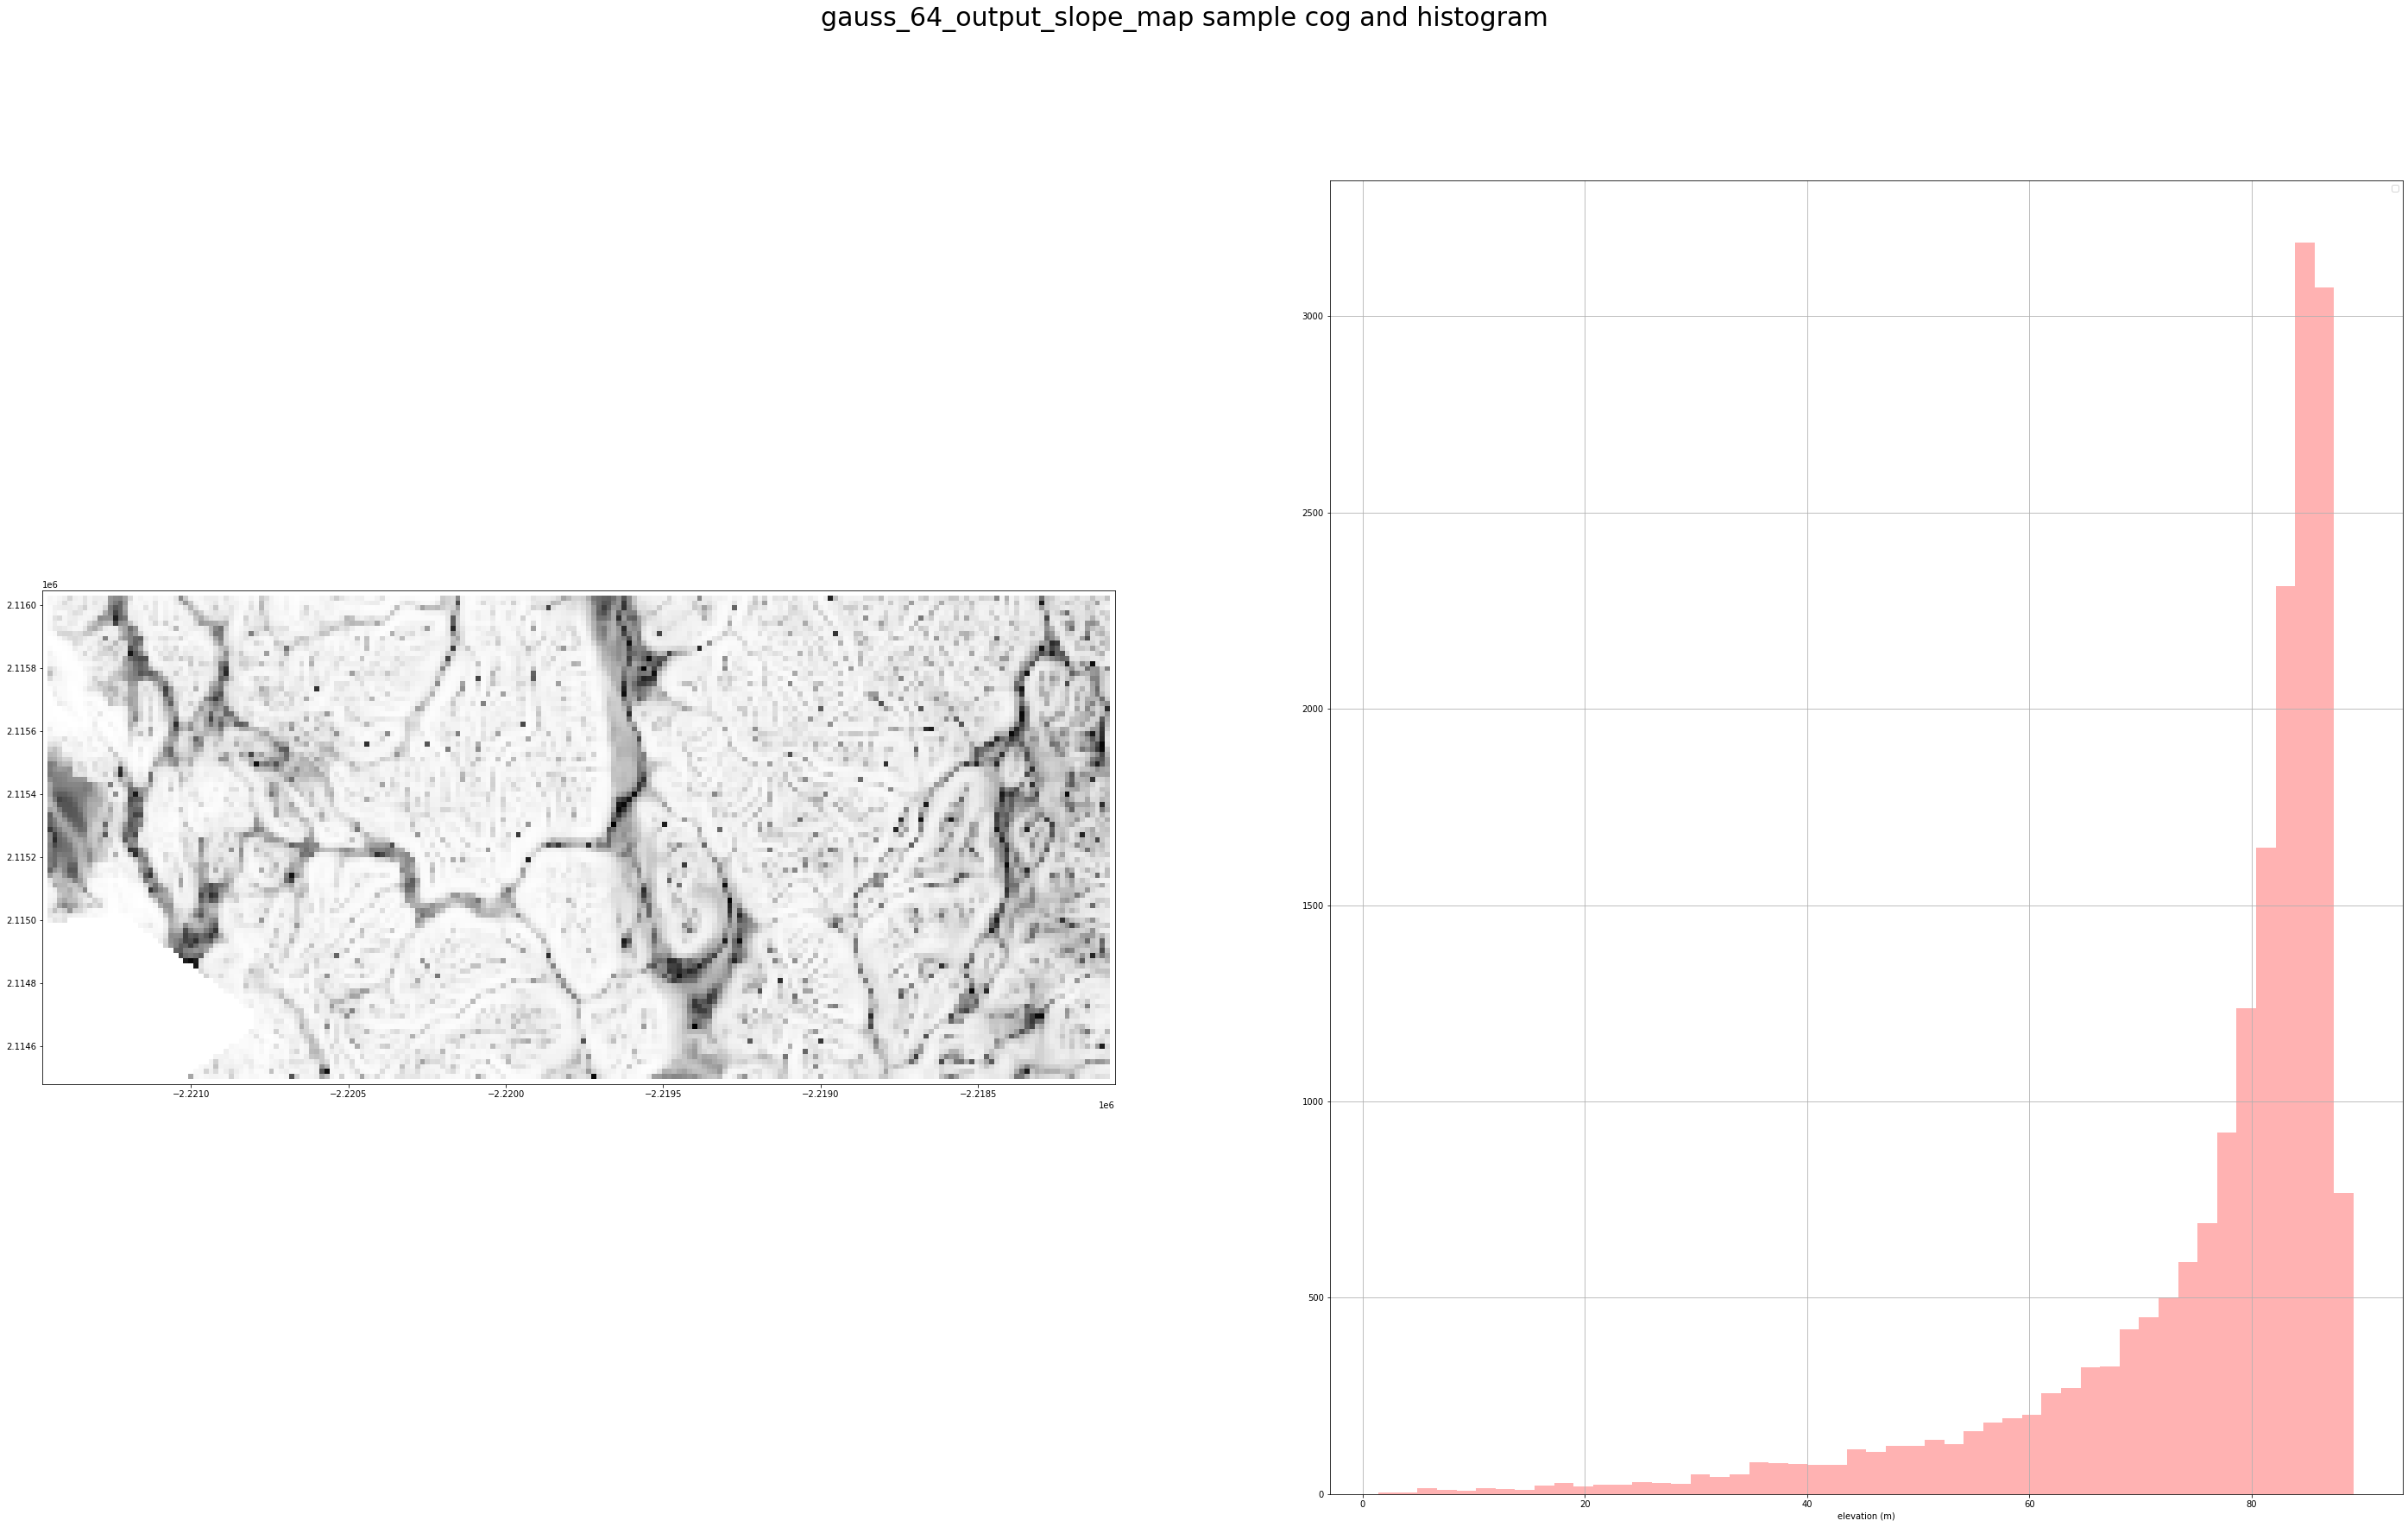

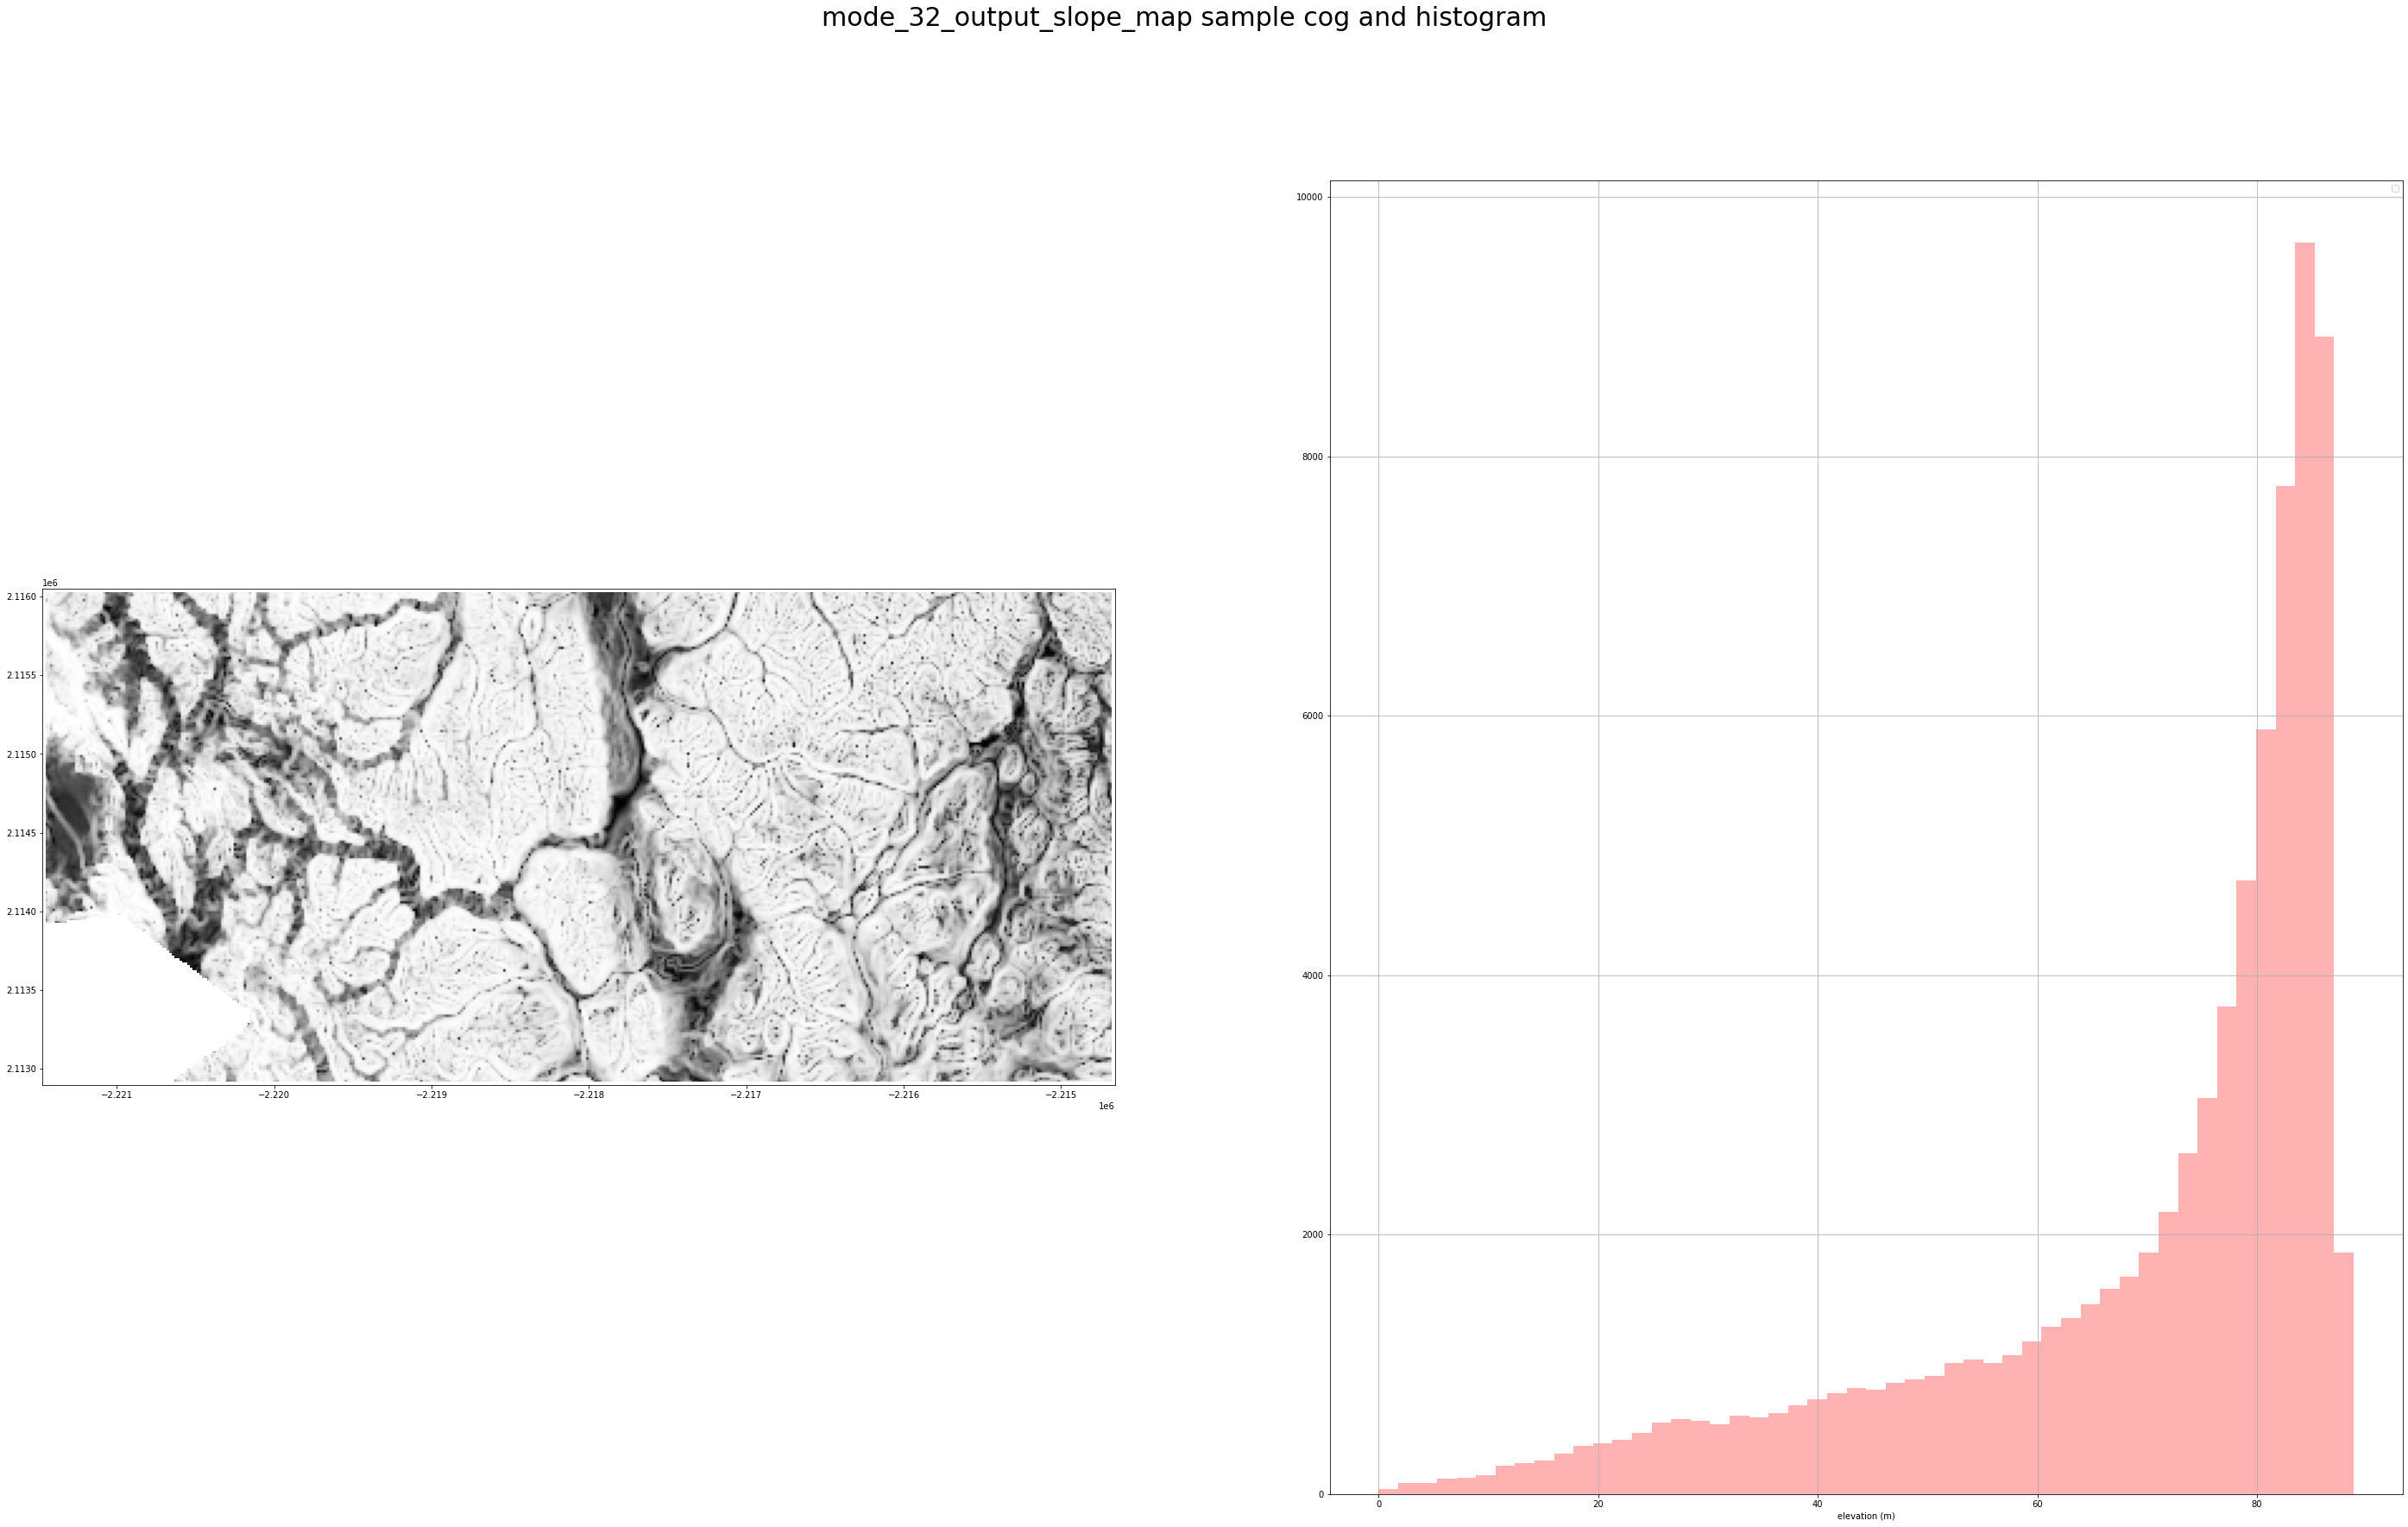

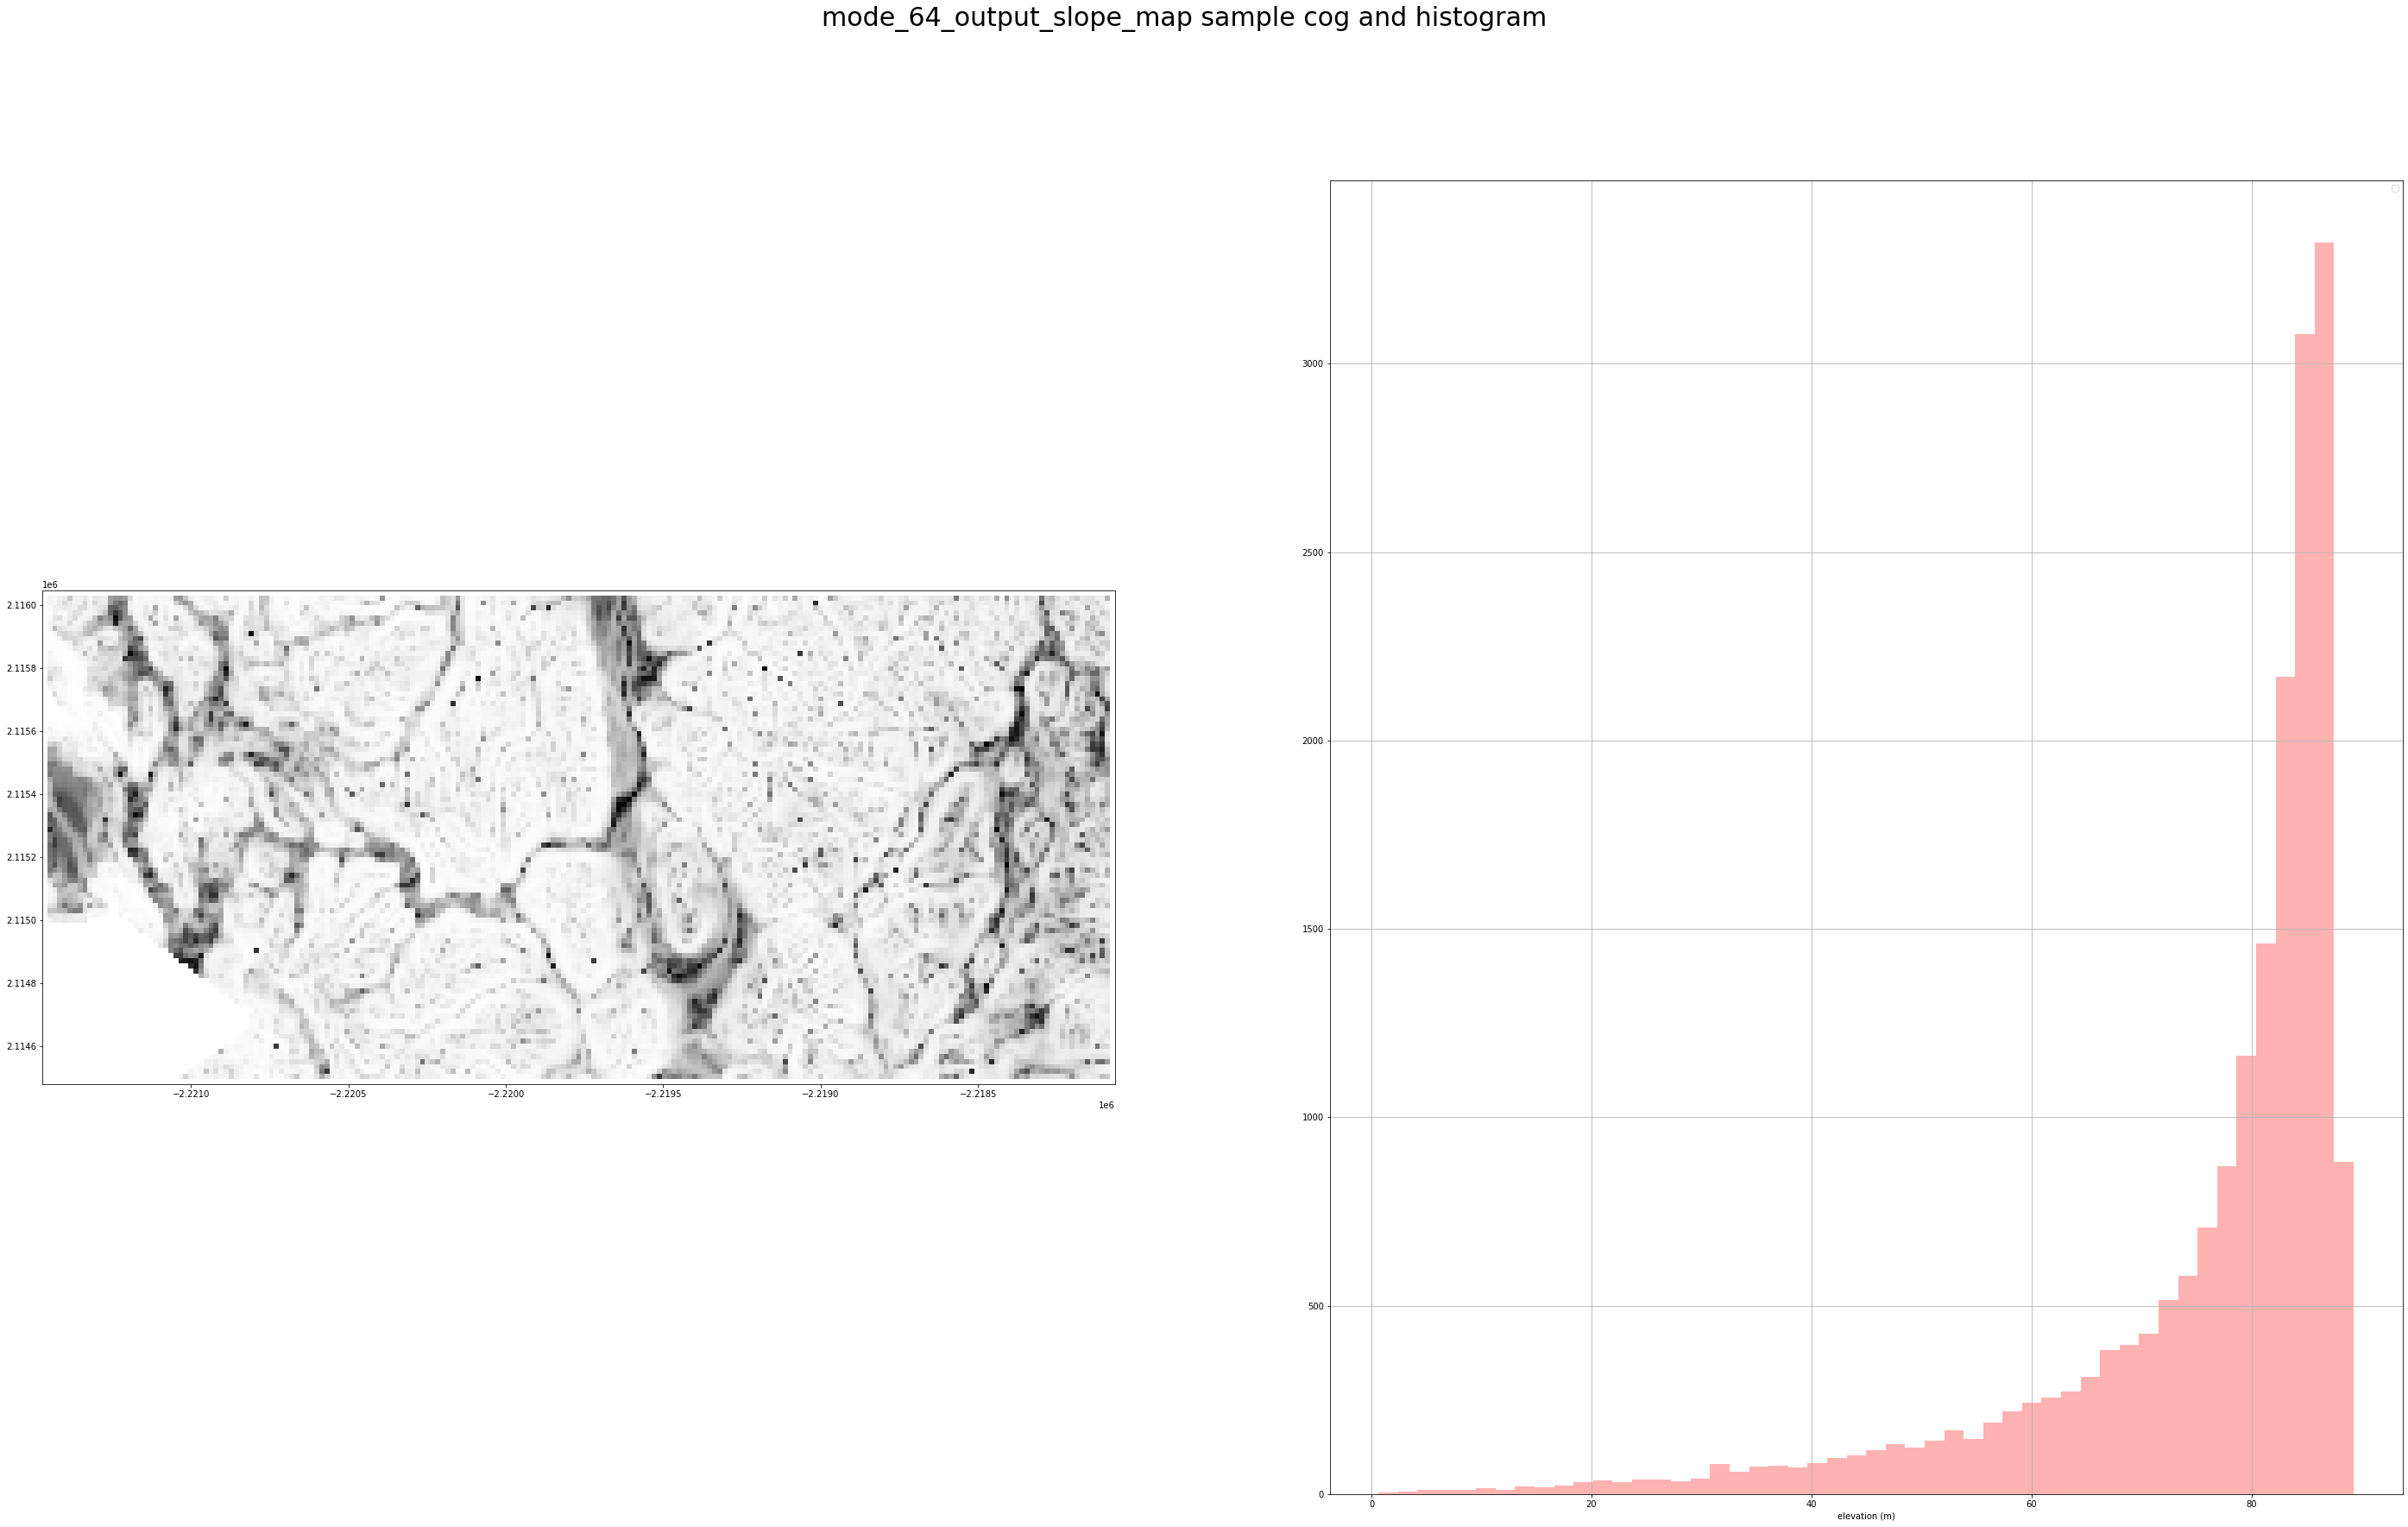

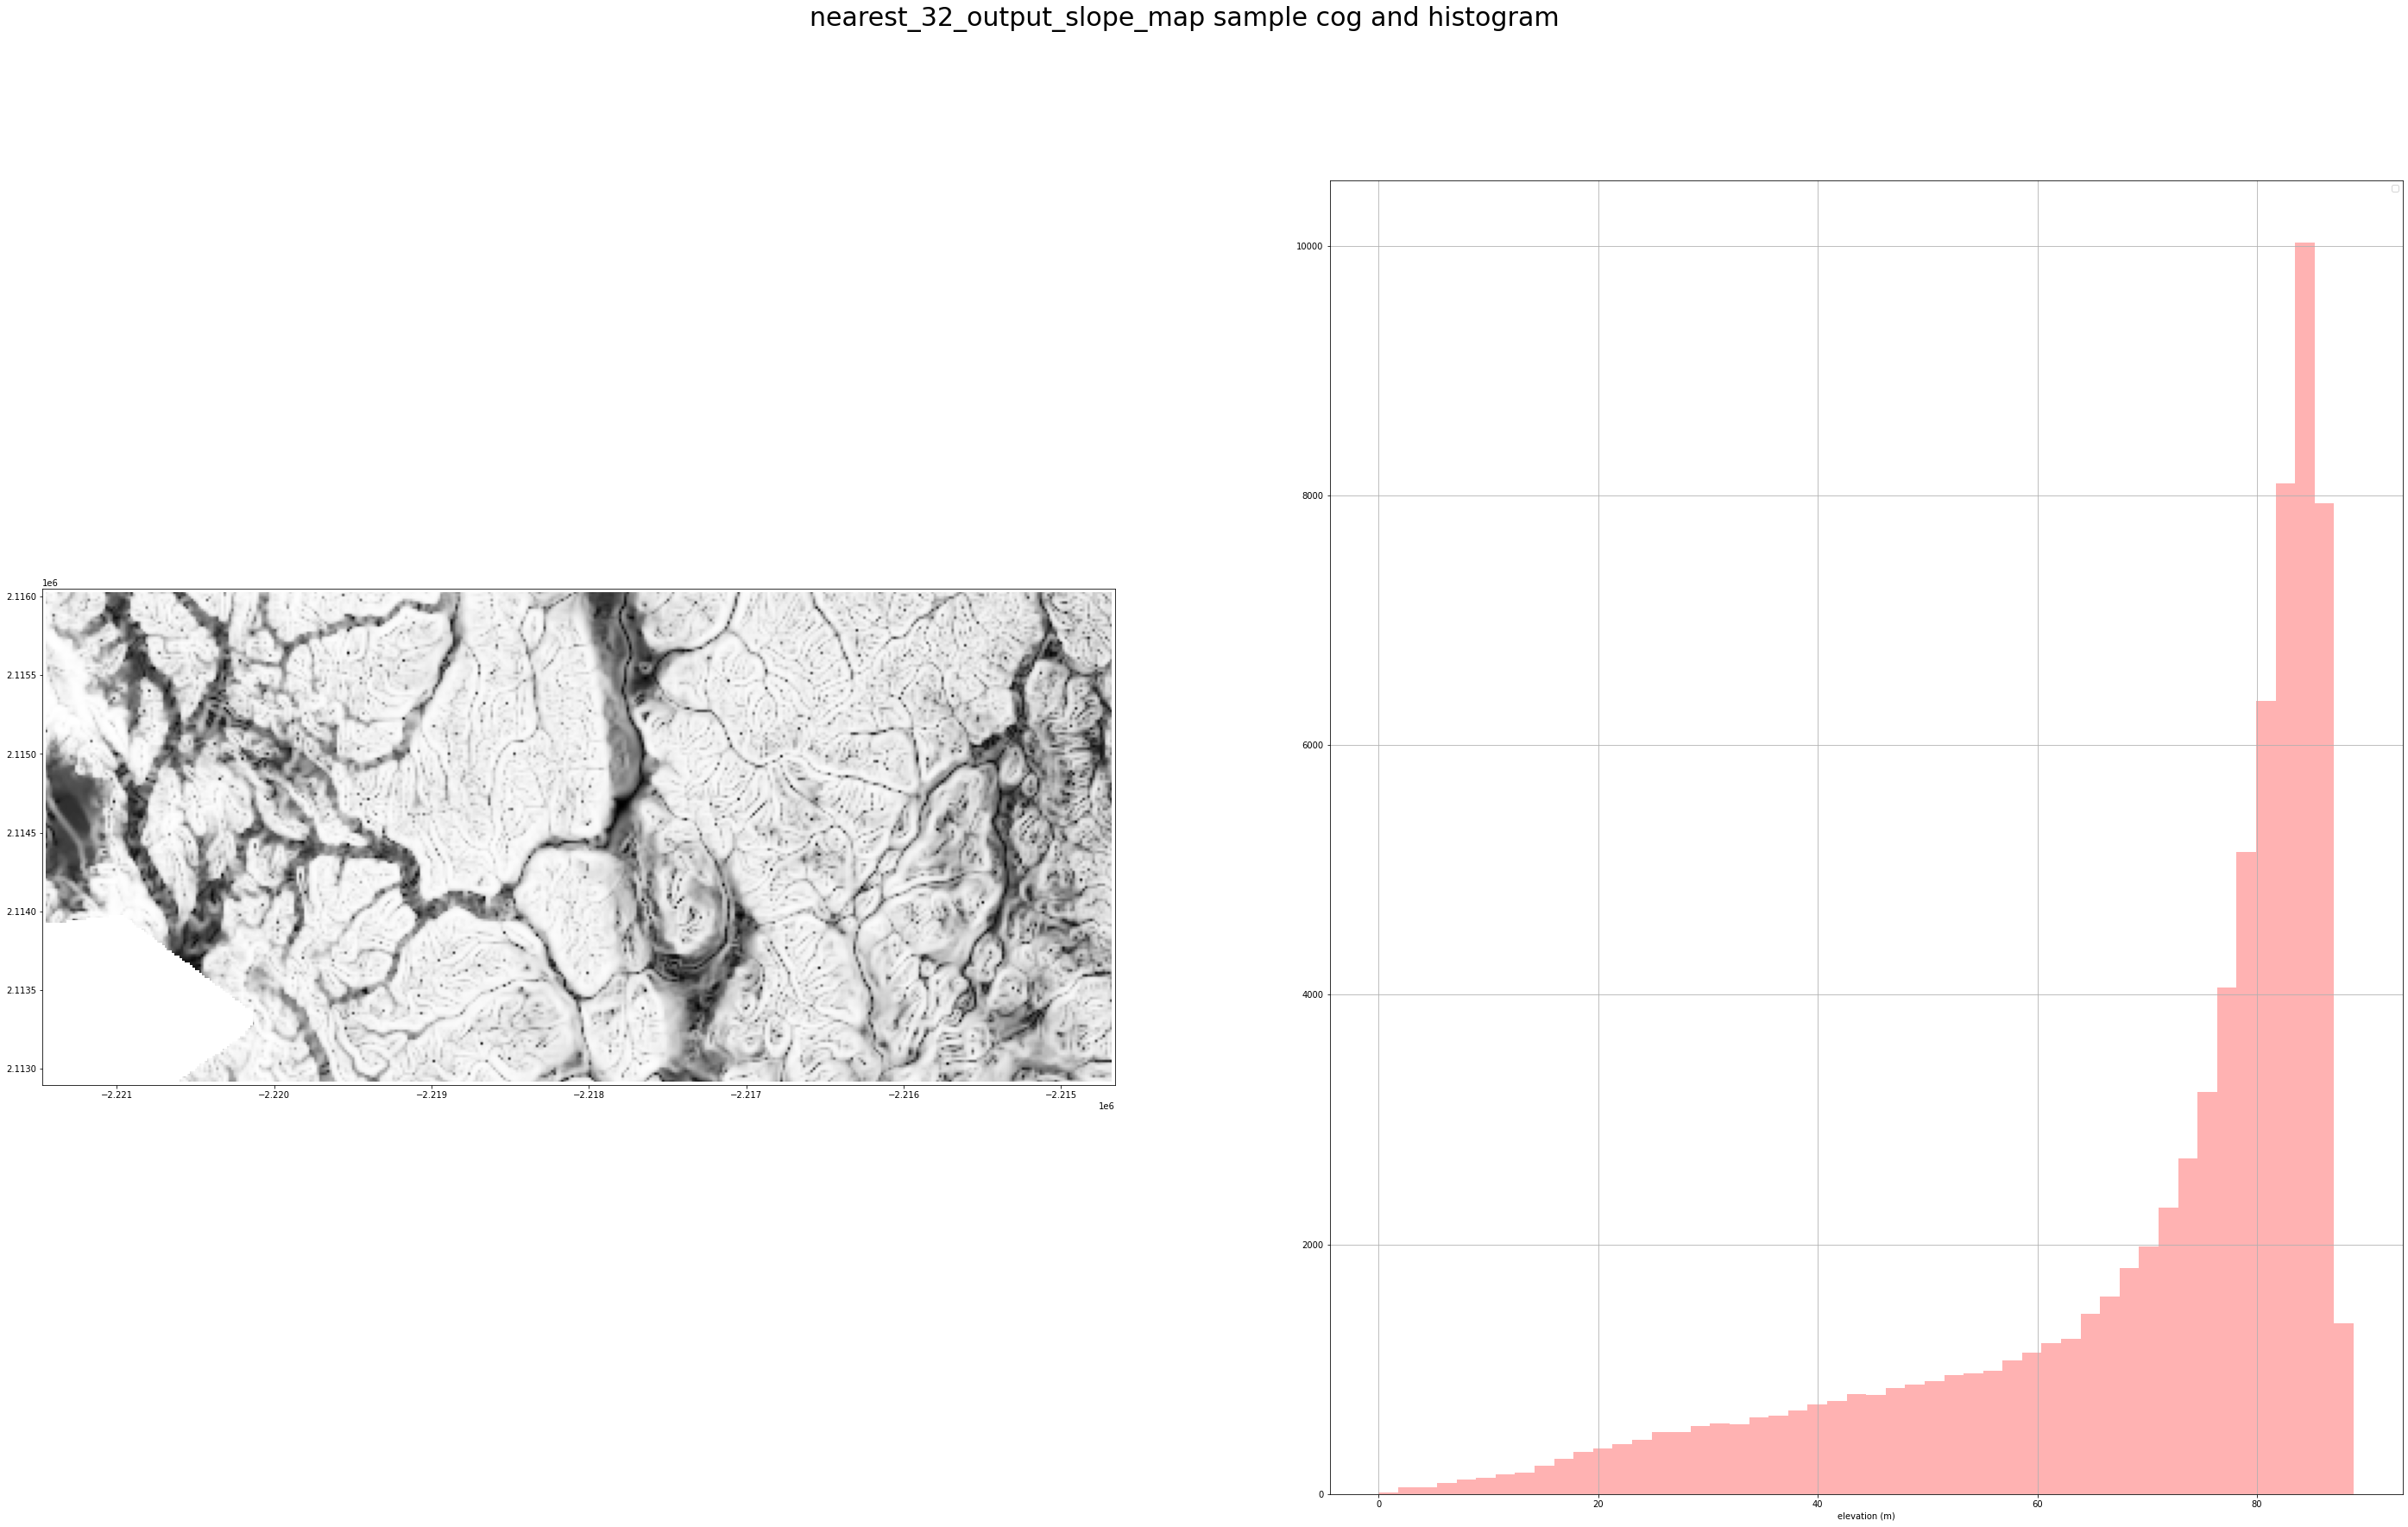

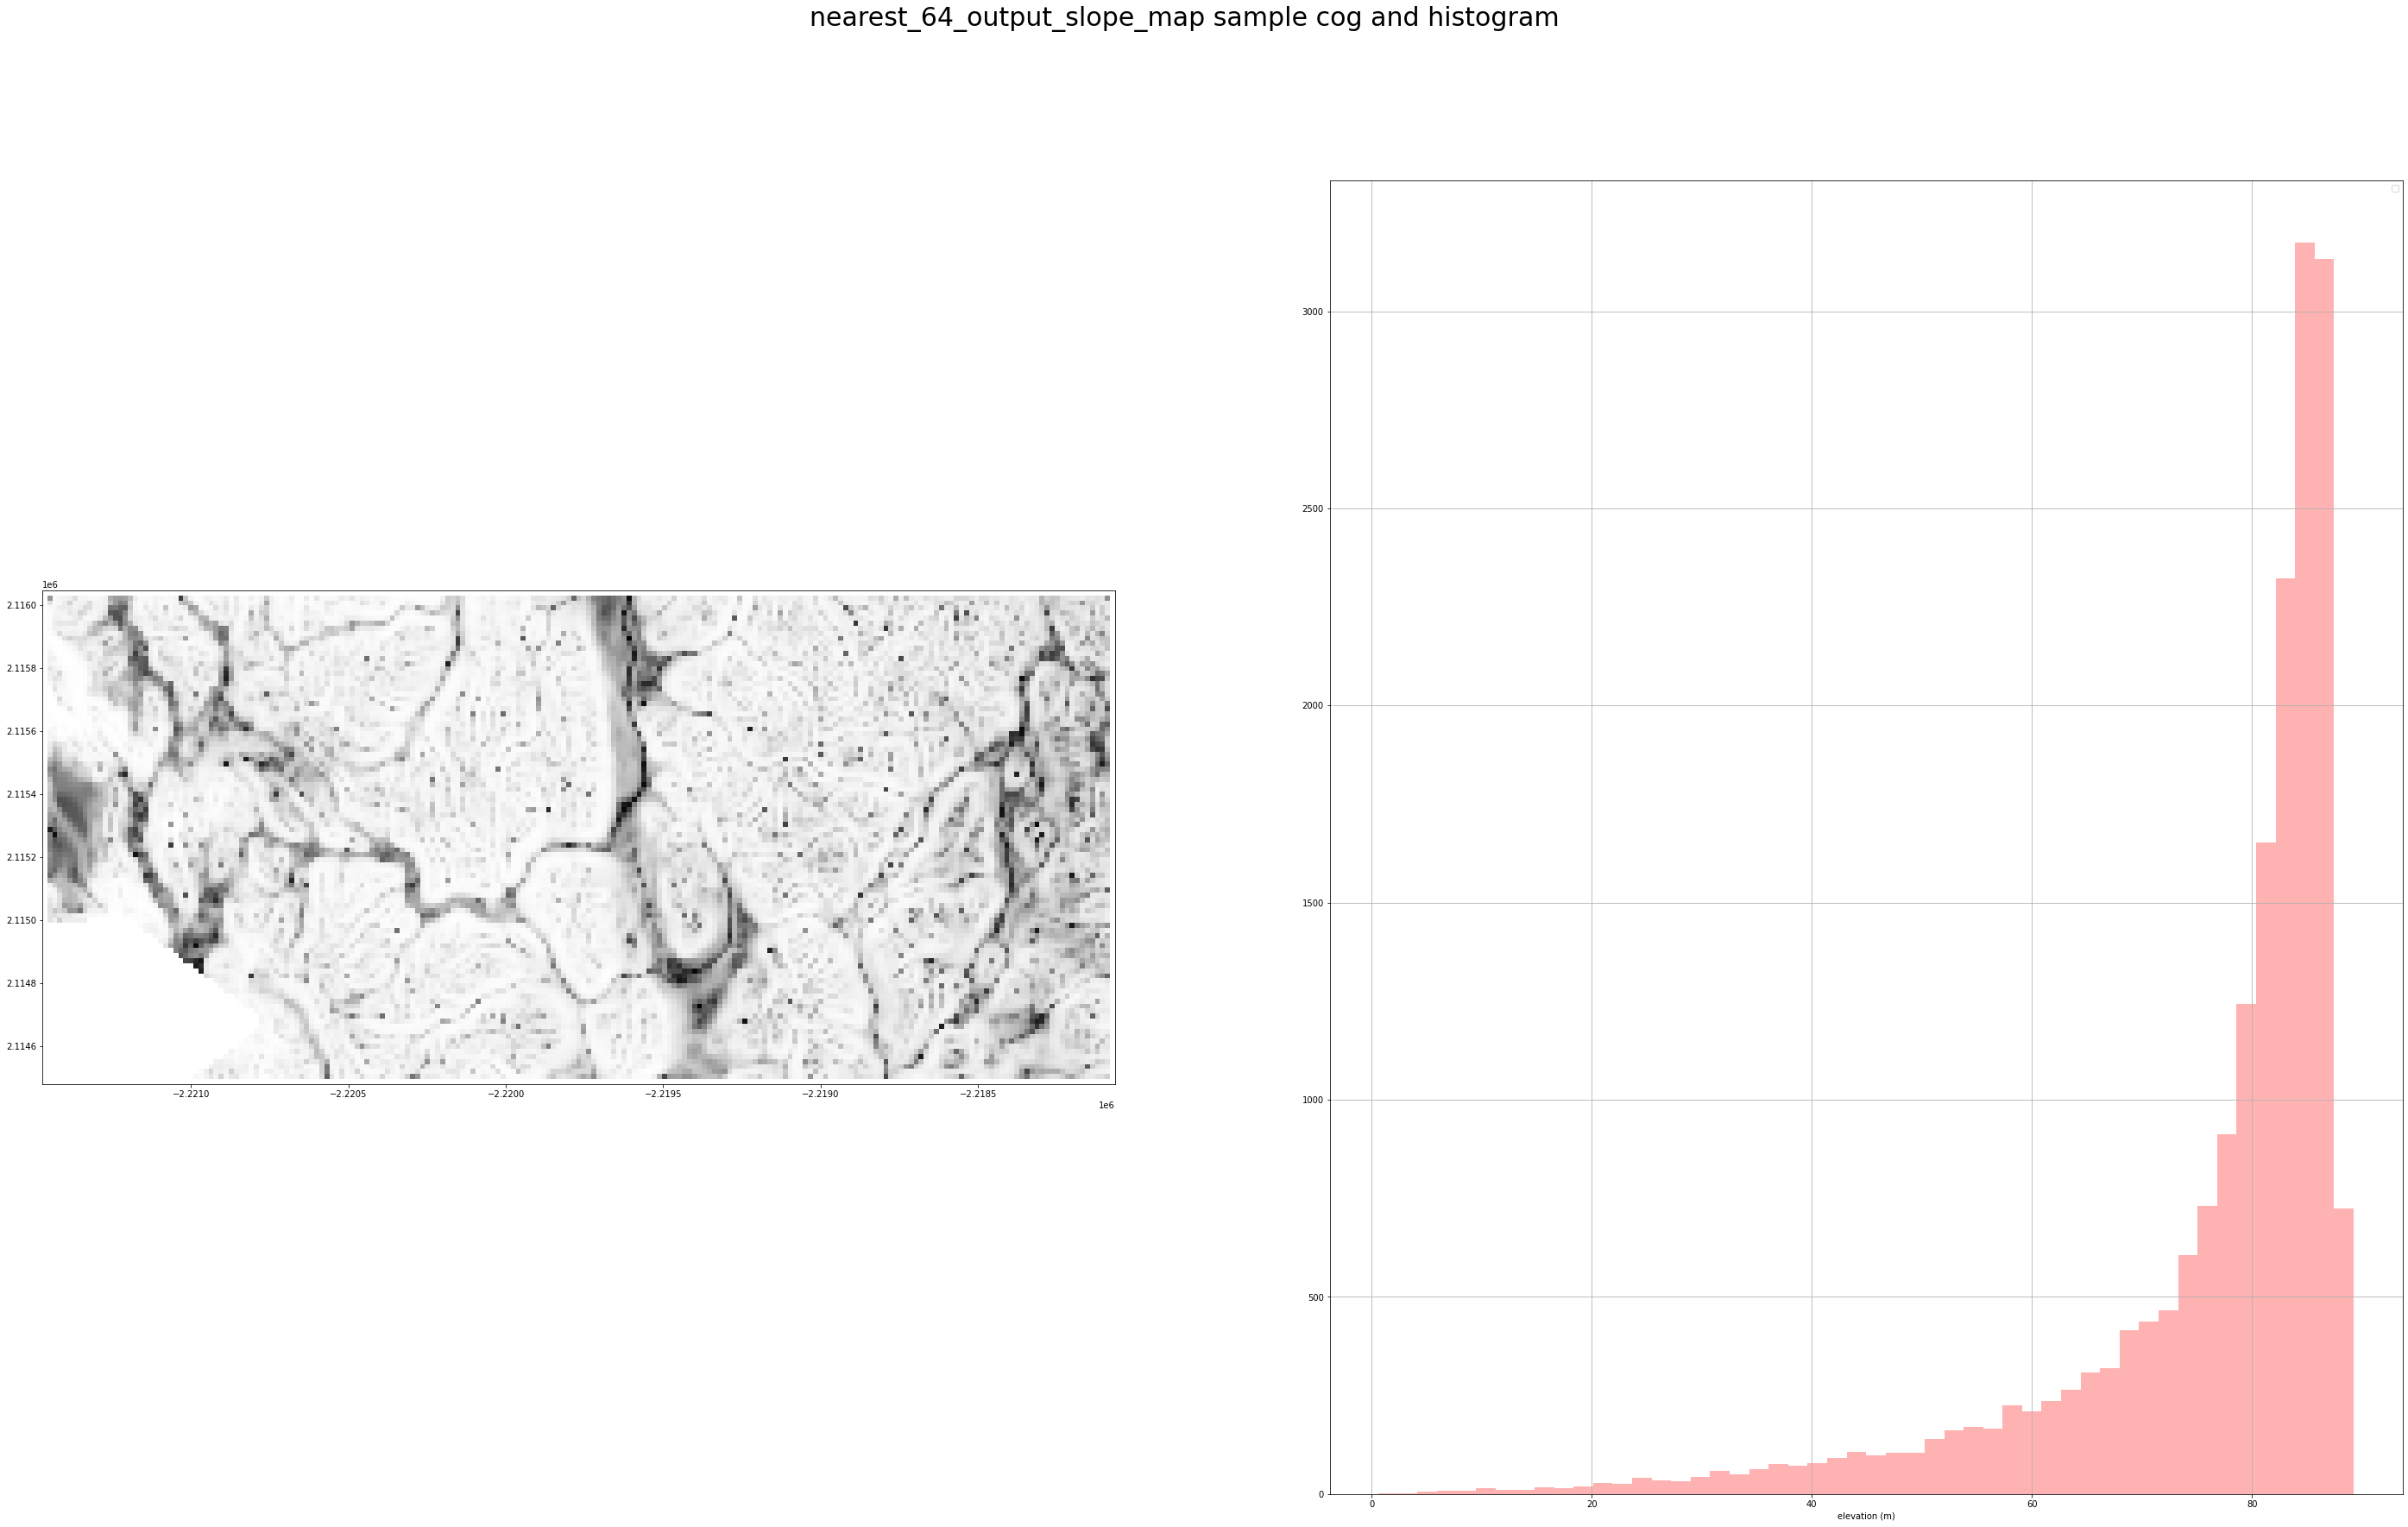

In [3]:
# create thumbnails and histograms of slope maps
path = "C:/Users/Owner/COOP4/PortableGit/nrcan-datacube/test_data/slope"
for filename in glob.glob(os.path.join(path, '*.tif')):
   with open(os.path.join(os.getcwd(), filename), 'r') as f: # open in readonly mode
    cog_sample = rasterio.open(filename)
    cur_name = os.path.basename(filename)[:-4]
    
    bound = str(cog_sample.bounds)
    crs = str(cog_sample.crs)
    dtype = str(cog_sample.dtypes[0])
    trans = str(cog_sample.transform)
    nodata = str(cog_sample.nodata)
    shape = str(cog_sample.shape)
    meta = str(cog_sample.meta)
    output = "{}_info".format(cur_name)
    f = open(output+'.txt',"w")
    f.write("stats: " + "\n" + 
            "bound: " + bound + "\n" + 
            "crs: " + crs + "\n" + 
            "dtype: " + dtype + 
            "transform: " + trans + 
            "nodata: " + nodata + 
            "shape: " + shape + 
            "metadata: " + meta)
    
    fig, (aximage, axhist) = pyplot.subplots(1, 2, figsize=(49,28))
    figtitle="{} sample cog and histogram".format(cur_name)
    fig.suptitle(figtitle,fontsize=30)
    #create histogram using rasterio show histogram, pass axes subplot handle to axhist
    bins=50
    show_hist(cog_sample, bins=bins, lw=0.0, 
              stacked=False, alpha=0.3,
              histtype='stepfilled',
              ax=axhist)
    axhist.set_title('')
    axhist.set_xlabel('elevation (m)')
    axhist.set_ylabel('')
    axhist.legend('')
    #create display image passing axes subplot handle to aximage
    show(cog_sample, cmap='gray',transform=cog_sample.transform, ax=aximage)
    #save the figure
    fname=path+cur_name+'.png'
    pyplot.savefig(fname,format='png')   

## Create statistics of all slope maps

In [4]:
# create csv files of slope maps
fields = ['Name', 'Resampling_Method', 'Overview', 'Driver', 'Data Type', 
          'crs', 'Width', 'Height', 'Nodata_Pixels', 'Pixels_with_Values',
          'Pixel_Size', 'Min', 'Max', 'Range', 'Q1', 'Q3', 'Mean', 'Median', 
          'Std', 'Var']
rows = [fields]

path = "C:/Users/Owner/COOP4/PortableGit/nrcan-datacube/test_data/slope"
for filename in glob.glob(os.path.join(path, '*.tif')):
   with open(os.path.join(os.getcwd(), filename), 'r') as f: # open in readonly mode
    cog = rasterio.open(filename)
    cur_name = os.path.basename(filename).split('_')[0]
    resampling = os.path.basename(filename)[:-7]
    overview = os.path.basename(filename).split('_')[1]
    
    # delete nodata value
    cog_ar = cog.read(1)
    cog_ar = numpy.where(cog_ar==cog.nodata,numpy.nan,cog_ar)
    
    # stats
    driver = str(cog.meta['driver'])
    dtype = str(cog.meta['dtype'])
    crs = str(cog.meta['crs'])
    width = cog.meta['width']
    height = cog.meta['height']
    nodata = len(cog_ar[numpy.isnan(cog_ar)])
    data_with_values = len(cog_ar[~numpy.isnan(cog_ar)])
    pixel_size = cog.transform[0]
    
    cog_min = numpy.nanmin(cog_ar)
    cog_max = numpy.nanmax(cog_ar)
    cog_range = cog_max-cog_min
    cog_q1 = numpy.nanquantile(cog_ar, 0.25)
    cog_q3 = numpy.nanquantile(cog_ar, 0.75)
    cog_mean = numpy.nanmean(cog_ar)
    cog_median = numpy.nanmedian(cog_ar)
    cog_std = numpy.nanstd(cog_ar)
    cog_var = numpy.nanvar(cog_ar)
    
    cur_row = [cur_name,
               resampling,
               overview,
               driver,
               dtype,
               crs,
               width,
               height,
               nodata,
               data_with_values,
               pixel_size,
               cog_min,
               cog_max,
               cog_range,
               cog_q1,
               cog_q3,
               cog_mean,
               cog_median,
               cog_std,
               cog_var]
    
    rows.append(cur_row)
    # name of csv file
    output = "C:/Users/Owner/COOP4/PortableGit/nrcan-datacube/test_data/stats_{}.csv".format(cur_name)
    
    # writing to csv file 
    with open(output, 'w',newline='') as csvfile: 
        csvwriter = csv.writer(csvfile) 
        csvwriter.writerow(fields) 
        csvwriter.writerow(cur_row)
        
# name of csv file
output = "{}/stats_all.csv".format(path)

# writing to csv file 
with open(output, 'w',newline='') as csvfile: 
    csvwriter = csv.writer(csvfile) 
    csvwriter.writerows(rows)